In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z'}, plus_minus: Optional[dict] = {0: 'z'}) -> QuantumCircuit:
    """For BB84, we take state to be '0', '1', '+', '-' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(1)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[0] == '+':
        qc.h(0)
    if state[0] == '-':
        qc.x(0)
        qc.h(0)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
                
    # apply the Hadamard to obtain + and - state
    for gate, hadamard in plus_minus.items():
        if gate > 1:
            raise ValueError('Provided H Gate number exceeds in the circuit for + or - State')
        else:
            if hadamard == 'h' or hadamard == 'H':
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('1',100))

        ┌───┐┌────────────────┐ ░ ┌─┐
     q: ┤ X ├┤ Delay(100[ns]) ├─░─┤M├
        └───┘└────────────────┘ ░ └╥┘
meas: 1/═══════════════════════════╩═
                                   0 


In [4]:
print(create_circuit('-',100,{0: 'z'},{0: 'h'}))

        ┌───┐┌───┐┌────────────────┐┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├┤ Delay(100[ns]) ├┤ H ├─░─┤M├
        └───┘└───┘└────────────────┘└───┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 


In [5]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","id"])
        
    
    return noise_model

In [6]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['delay', 'h', 'measure', 'x', 'id']>

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['delay', 'measure']>

In [8]:
noise_params = {"T1":193020, "T2":257470} # ibmq_armonk T1: 193.02 , T2:257.47 us
q1_gate_len = 71.11 
measure_len = 4977.778 # ibmq_armonk  4977.778 

In [9]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for BB84 protocol"""
    """Channel: 1 => |0>+|1>, 2 => |0>+|1> 3 =>|0>+|1>  4=>|0>+|1> """
    
    if channel == '1':
        state = '0'
    elif channel == '2':
        state = '1'
    elif channel == '3':
        state = '+'
    elif channel == '4':
        state = '-'  
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    #print(counts)
    success = 0
    
    if channel == '1':
        if '0' in counts.keys():
            success += counts['0']
        else:
            success +=0
#         if '1' in counts.keys():
#             success += counts['1']
    elif channel == '2':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']
        else:
            success +=0
    elif channel == '3':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
    elif channel == '4':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
            
    
    return float(success/shots)

In [10]:
run('2',1000,{"delay": True, "measure": True, "gate": True})

0.973

In [11]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

1.0

In [14]:
run('3',1000,{"delay": True, "measure": True, "gate": True})

0.998

In [13]:
run('4',1000,{"delay": True, "measure": True, "gate": True})

0.988

# Probability of Success Graph

In [14]:
import matplotlib.pyplot as plt

delay = np.arange(0,1001000,1000)
channel = '1'
apply_error = {"delay":True, "measure": True, "gate": True}
success = []

# need to run in multiple loops to get a smoother curve
for d in range(len(delay)):
    prob = run(channel,int(delay[d]),apply_error)
    success.append(prob)

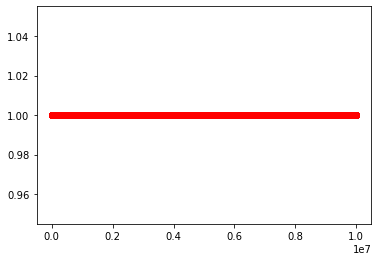

In [16]:
plt.plot(delay,success,'ro--')
plt.show()

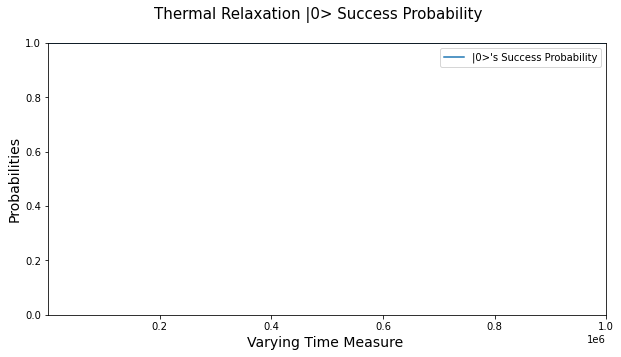

<Figure size 576x360 with 0 Axes>

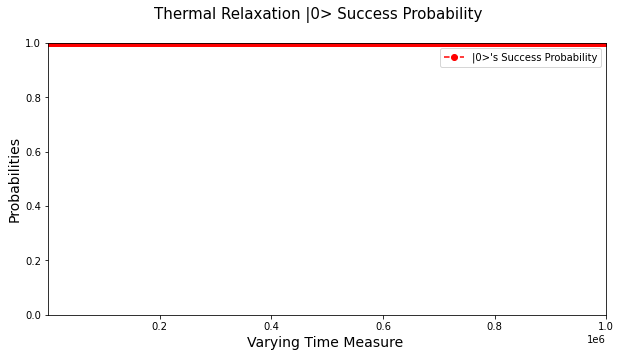

<Figure size 576x360 with 0 Axes>

In [15]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |0> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "|0>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |0> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "|0>'s Success Probability")
ax.legend()

# for state 1

In [ ]:
# Delay 

import matplotlib.pyplot as plt
success_state1_3=[]
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success_state1_3.append(success)

from statistics import mean
a= success_state1_3
print(*map(mean, zip(*a)))

In [28]:
# Delay +Measure

import matplotlib.pyplot as plt
success_state1_3=[]
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success_state1_3.append(success)

from statistics import mean
a= success_state1_3
print(*map(mean, zip(*a)))


0.9746 0.9693499999999999 0.9642 0.95795 0.9548 0.9501499999999999 0.9470999999999999 0.9380499999999999 0.9372 0.93075 0.9235 0.9207000000000001 0.91485 0.91045 0.90825 0.9024 0.8973 0.892 0.8914 0.88235 0.8733 0.87255 0.8699 0.8621 0.86205 0.8525 0.8514499999999999 0.8466 0.84355 0.83905 0.8331999999999999 0.8319 0.8277 0.8190999999999999 0.8184 0.8156 0.8112 0.8018500000000001 0.80425 0.79035 0.7938500000000001 0.79305 0.78185 0.78195 0.7736000000000001 0.77305 0.76865 0.76615 0.766 0.7528 0.75575 0.74745 0.74765 0.74235 0.736 0.7321 0.7323 0.72775 0.71755 0.7199 0.7142 0.7072999999999999 0.7018 0.7085 0.69955 0.69065 0.6896 0.69255 0.6869 0.68315 0.6818500000000001 0.6753 0.6728000000000001 0.66625 0.667 0.6594 0.66215 0.6501 0.64545 0.64295 0.6469 0.6392 0.63665 0.6359 0.6274 0.6197 0.62625 0.6149 0.62155 0.61365 0.6134499999999999 0.6073 0.6073 0.6041 0.5985 0.59605 0.5885 0.5909 0.5879 0.57855 0.5802499999999999 0.5765 0.5733 0.5673 0.56715 0.5645 0.56545 0.5632 0.5562 0.5506 0.

# Delay +measure + gates

In [14]:
import matplotlib.pyplot as plt
success_state1=[]
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success_state1.append(success)

In [15]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.97455 0.9687 0.96315 0.9595 0.95355 0.9522499999999999 0.94335 0.9395 0.93785 0.9294 0.9269000000000001 0.9199 0.91405 0.9136000000000001 0.9041 0.8989 0.898 0.8958 0.8892 0.8847 0.87885 0.8721 0.8699 0.86115 0.8614499999999999 0.8516 0.8516 0.84955 0.84015 0.8369 0.8342999999999999 0.82855 0.82805 0.81495 0.8176 0.81835 0.8066 0.80635 0.798 0.797 0.79045 0.78835 0.7847000000000001 0.779 0.7753 0.7719 0.7666000000000001 0.76635 0.75385 0.75725 0.7534 0.7489 0.748 0.74155 0.7337 0.7316 0.73025 0.7284999999999999 0.7211 0.7133999999999999 0.7119 0.7081999999999999 0.7112999999999999 0.6971499999999999 0.7008 0.70005 0.6948 0.6871 0.68505 0.6788000000000001 0.6739 0.6706 0.6717500000000001 0.6681 0.66225 0.6519 0.6607500000000001 0.6501 0.6513 0.64705 0.6458 0.6434 0.6372 0.63525 0.6323 0.62545 0.6234 0.62075 0.61825 0.61015 0.61485 0.60675 0.6058 0.6003 0.60065 0.59155 0.59065 0.5861 0.58575 0.5879 0.58255 0.5777 0.5717 0.5696 0.568 0.5665 0.55775 0.56465 0.5532 0.5522 0.5486 0.5498000

In [16]:
bb84_state_1_4=[0.97455,0.9687,0.96315,0.9595,0.95355,0.9522499999999999,0.94335,0.9395,0.93785,0.9294,0.9269000000000001,0.9199,0.91405,0.9136000000000001,0.9041,0.8989,0.898,0.8958,0.8892,0.8847,0.87885,0.8721,0.8699,0.86115,0.8614499999999999,0.8516,0.8516,0.84955,0.84015,0.8369,0.8342999999999999,0.82855,0.82805,0.81495,0.8176,0.81835,0.8066,0.80635,0.798,0.797,0.79045,0.78835,0.7847000000000001,0.779,0.7753,0.7719,0.7666000000000001,0.76635,0.75385,0.75725,0.7534,0.7489,0.748,0.74155,0.7337,0.7316,0.73025,0.7284999999999999,0.7211,0.7133999999999999,0.7119,0.7081999999999999,0.7112999999999999,0.6971499999999999,0.7008,0.70005,0.6948,0.6871,0.68505,0.6788000000000001,0.6739,0.6706,0.6717500000000001,0.6681,0.66225,0.6519,0.6607500000000001,0.6501,0.6513,0.64705,0.6458,0.6434,0.6372,0.63525,0.6323,0.62545,0.6234,0.62075,0.61825,0.61015,0.61485,0.60675,0.6058,0.6003,0.60065,0.59155,0.59065,0.5861,0.58575,0.5879,0.58255,0.5777,0.5717,0.5696,0.568,0.5665,0.55775,0.56465,0.5532,0.5522,0.5486,0.5498000000000001,0.53995,0.5425,0.53835,0.5436,0.5323,0.5306000000000001,0.5326500000000001,0.53305,0.5177,0.5163,0.5186000000000001,0.5155000000000001,0.5123,0.51005,0.5092,0.5053,0.5085,0.4967,0.5028,0.4997,0.4908,0.49265,0.48875,0.48719999999999997,0.48045,0.47435,0.48085,0.47815,0.47104999999999997,0.4767,0.46545000000000003,0.46265,0.46305,0.45555,0.45765,0.45790000000000003,0.45640000000000003,0.44730000000000003,0.4501,0.44875,0.4364,0.4362,0.4409,0.433,0.4327,0.4355,0.42969999999999997,0.42885,0.41875,0.42075,0.42464999999999997,0.4225,0.4195,0.41075,0.4147,0.414,0.4094,0.40505,0.40245000000000003,0.4131,0.39625,0.3988,0.3972,0.3927,0.388,0.39545,0.3852,0.38880000000000003,0.37855,0.3807,0.38535,0.37595,0.37625,0.37885,0.36445,0.3718,0.36425,0.37205,0.3654,0.36265,0.3562,0.35825,0.3613,0.3514,0.3523,0.3478,0.35305,0.3423,0.3472,0.3499,0.3387,0.33695,0.3395,0.3422,0.33815,0.3313,0.3337,0.32615,0.3296,0.3279,0.3229,0.33015,0.32035,0.32615,0.3162,0.316,0.3157,0.3181,0.3142,0.31235,0.3157,0.3036,0.30419999999999997,0.3021,0.29725,0.30265,0.3039,0.30165,0.2958,0.2967,0.29159999999999997,0.2945,0.29165,0.2917,0.2864,0.2842,0.2821,0.28315,0.2831,0.27695000000000003,0.2786,0.27495,0.27535,0.27845,0.27165,0.2656,0.27055,0.2688,0.265,0.26665,0.2682,0.26205,0.2596,0.25935,0.2566,0.25680000000000003,0.2596,0.25625,0.2549,0.25245,0.251,0.2498,0.24675,0.24505,0.2455,0.24525,0.24375,0.24015,0.24035,0.23915,0.23695,0.2336,0.2393,0.23225,0.2412,0.23365,0.22705,0.22875,0.22455,0.23065,0.22785,0.2268,0.2288,0.22245,0.21915,0.21845,0.2216,0.21665,0.2201,0.2154,0.21235,0.2118,0.2138,0.20785,0.21185,0.2063,0.20395,0.2081,0.20115,0.20195,0.19615,0.20299999999999999,0.20305,0.1968,0.19705,0.19835,0.2022,0.19385,0.1963,0.194,0.1912,0.19005,0.18765,0.19415,0.191,0.18325,0.18765,0.1892,0.1869,0.1787,0.18259999999999998,0.18675,0.1815,0.177,0.17675,0.18125,0.1747,0.17785,0.1787,0.17895,0.1726,0.17195,0.1737,0.17205,0.1734,0.17265,0.17335,0.1674,0.1676,0.164,0.1679,0.1654,0.16105,0.16275,0.1617,0.1578,0.15675,0.1587,0.15585,0.16085,0.1603,0.15495,0.15375,0.1571,0.15075,0.1558,0.15365,0.1523,0.1545,0.15145,0.14835,0.14945,0.14625,0.14795,0.1532,0.14315,0.1462,0.14305,0.1425,0.14335,0.14035,0.13975,0.14015,0.14035,0.139,0.13765,0.1394,0.1341,0.13475,0.1354,0.13465,0.133,0.1328,0.1341,0.12840000000000001,0.1315,0.1311,0.13335,0.12535,0.1325,0.12735,0.1295,0.125,0.126,0.1268,0.1264,0.1231,0.1237,0.11750000000000001,0.122,0.12265,0.1197,0.1214,0.12040000000000001,0.1174,0.11985,0.11365,0.1176,0.11525,0.1139,0.11745,0.1165,0.11355,0.11255,0.10845,0.11515,0.10935,0.1109,0.1114,0.1129,0.10815,0.10755,0.10935,0.11015,0.10785,0.1086,0.10395,0.10389999999999999,0.10495,0.1048,0.10315,0.1051,0.1037,0.10295,0.1021,0.1036,0.1043,0.09845,0.0998,0.0984,0.09825,0.09605,0.09425,0.0988,0.10024999999999999,0.09675,0.0973,0.09465,0.09475,0.0968,0.09575,0.09025,0.093,0.09230000000000001,0.0922,0.0917,0.09175,0.09055,0.08985,0.08895,0.0902,0.08875,0.08915000000000001,0.0881,0.0886,0.08425,0.08745,0.08805,0.088,0.0857,0.0829,0.0831,0.0882,0.0831,0.0855,0.0802,0.07925,0.0834,0.07995,0.08105,0.08195,0.08115,0.07825,0.0784,0.0777,0.07605,0.0764,0.07795,0.07585,0.0801,0.0775,0.07315,0.0723,0.07605,0.07315,0.07125000000000001,0.0775,0.0757,0.07005,0.0716,0.0702,0.07305,0.0706,0.0709,0.06985,0.07215,0.07105,0.06945,0.06805,0.07100000000000001,0.0681,0.06795,0.0663,0.07005,0.06585,0.0661,0.06865,0.0684,0.06485,0.0658,0.0626,0.06765,0.06575,0.06645,0.0642,0.06420000000000001,0.06405,0.06695,0.06695,0.0649,0.0621,0.06315,0.0638,0.061649999999999996,0.06420000000000001,0.06215,0.0617,0.0591,0.057050000000000003,0.058499999999999996,0.05845,0.05955,0.0582,0.0564,0.0568,0.058,0.05675,0.0568,0.05765,0.0523,0.0583,0.0549,0.05515,0.05275,0.05245,0.05455,0.0582,0.05005,0.052,0.0524,0.0523,0.05495,0.05225,0.051449999999999996,0.0535,0.05155,0.0499,0.05095,0.0525,0.0512,0.04925,0.0526,0.04925,0.0508,0.0483,0.05055,0.04635,0.0483,0.0477,0.04665,0.05,0.048,0.04765,0.04645,0.04965,0.047599999999999996,0.04605,0.0436,0.0468,0.04835,0.04545,0.0431,0.0461,0.0451,0.04235,0.04665,0.0456,0.0443,0.0433,0.0427,0.04385,0.0434,0.0461,0.03815,0.04295,0.04165,0.04255,0.04205,0.0416,0.0391,0.0405,0.04105,0.03955,0.0398,0.0423,0.038400000000000004,0.04065,0.0417,0.0393,0.03945,0.0376,0.03695,0.039,0.0383,0.03665,0.03655,0.0373,0.03805,0.0363,0.037,0.0375,0.0369,0.03675,0.03635,0.03515,0.03485,0.03545,0.0381,0.0343,0.03705,0.03535,0.0331,0.03305,0.03425,0.0363,0.03445,0.0334,0.0358,0.03185,0.0315,0.03375,0.034300000000000004,0.03325,0.0341,0.03135,0.03055,0.03175,0.0343,0.0305,0.03205,0.03225,0.030950000000000002,0.03205,0.03125,0.0317,0.02995,0.02805,0.027,0.03025,0.0309,0.032100000000000004,0.02845,0.0285,0.02825,0.02795,0.02805,0.0291,0.027800000000000002,0.028650000000000002,0.02655,0.03045,0.02705,0.02955,0.02935,0.0262,0.02725,0.02995,0.0264,0.0281,0.02665,0.026949999999999998,0.0266,0.0263,0.0271,0.0253,0.0254,0.02345,0.02575,0.0246,0.02825,0.0271,0.02625,0.02565,0.02535,0.027,0.0251,0.0258,0.02475,0.0246,0.02335,0.0257,0.02525,0.0244,0.0213,0.024,0.02455,0.0209,0.02445,0.0233,0.02195,0.0221,0.02325,0.0223,0.0218,0.02405,0.0212,0.02205,0.02275,0.02245,0.02135,0.02215,0.0217,0.0219,0.022350000000000002,0.0217,0.02105,0.0206,0.0194,0.021,0.021,0.0224,0.0205,0.0197,0.0212,0.0219,0.01855,0.0204,0.0204,0.01915,0.0202,0.02045,0.01925,0.01955,0.0199,0.019200000000000002,0.0212,0.0179,0.01895,0.01865,0.0187,0.01905,0.0176,0.02,0.02015,0.01935,0.0196,0.0181,0.0175,0.01635,0.01845,0.016900000000000002,0.0184,0.0189,0.01825,0.0195,0.01855,0.0177,0.01705,0.01625,0.01745,0.0169,0.01655,0.01775,0.0172,0.01695,0.015050000000000001,0.01495,0.01595,0.0158,0.018,0.01555,0.01745,0.01545,0.01535,0.01405,0.01665,0.01625,0.0158,0.01505,0.01395,0.01645,0.01555,0.0141,0.01565,0.01485,0.01695,0.0157,0.01385,0.0164,0.01485,0.015600000000000001,0.01455,0.01375,0.01625,0.0143,0.0157,0.01545,0.0151,0.0137,0.01405,0.01345,0.01405,0.0128,0.0147,0.0125,0.0148,0.014199999999999999,0.01335,0.01355,0.0137,0.0133,0.01395,0.0106,0.0135,0.013,0.0131,0.0141,0.01235,0.0117,0.0114,0.01205,0.0113,0.0124,0.011899999999999999,0.01245,0.01215,0.0123,0.0114,0.01265,0.012199999999999999,0.0119,0.013,0.012199999999999999,0.01185,0.0115,0.0123,0.0115,0.01175,0.011349999999999999,0.012199999999999999,0.01205,0.010199999999999999,0.0108,0.0108,0.01045,0.01175,0.0121,0.0101,0.0111,0.0103,0.01095,0.01185,0.0115,0.00995,0.010499999999999999,0.0098,0.0105,0.00925,0.0103,0.00955,0.0096,0.00885,0.0091,0.01055,0.00915,0.0097,0.00995,0.00955,0.01035,0.01,0.0099,0.00885,0.0093,0.00845,0.009,0.01005,0.0094,0.00935,0.01035,0.00985,0.00865,0.00825,0.00835,0.01035,0.008,0.0088,0.00885,0.008150000000000001,0.0101,0.0083,0.0091,0.00925,0.0082,0.009899999999999999,0.0075,0.0076,0.00925,0.00865,0.00835,0.0087,0.0088,0.00745,0.0086,0.00865,0.007899999999999999,0.00725,0.00835,0.0078,0.00815,0.0073,0.00945,0.00795,0.00805,0.00675,0.00715,0.00735,0.00785,0.00855,0.00755,0.0064,0.0073999999999999995,0.00735,0.00775,0.0072,0.0065,0.0078,0.00745,0.0071,0.0081,0.00655,0.00775,0.007,0.00735,0.0068000000000000005,0.00595,0.0068000000000000005,0.00715,0.00595,0.0072,0.0068,0.0064,0.00605,0.007,0.0065,0.00655,0.00685,0.00625,0.00725,0.00525,0.0068,0.0056500000000000005,0.00555,0.006,0.00525,0.00745,0.00705,0.0058000000000000005,0.0054,0.00525,0.0059,0.0057,0.00555,0.007,0.0053,0.0058000000000000005,0.00555,0.00495,0.005,0.0054,0.00605,0.00695,0.00685,0.00525,0.00535,0.00575,0.0051,0.0061,0.0057,0.0043]

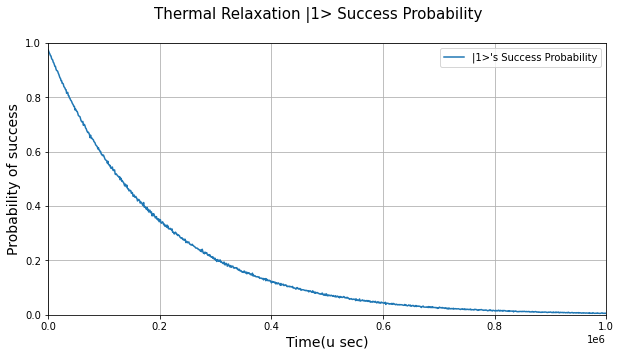

<Figure size 576x360 with 0 Axes>

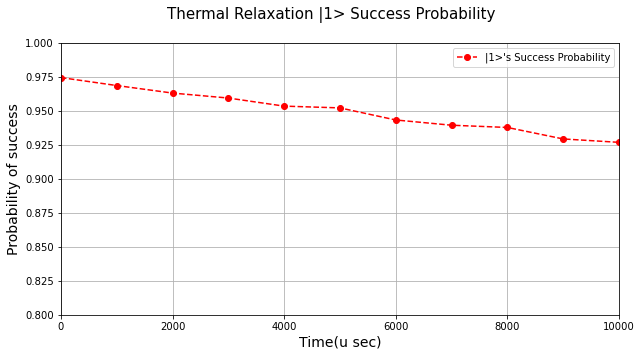

<Figure size 576x360 with 0 Axes>

In [17]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,bb84_state_1_4,label = "|1>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 10000)
ax.set_ylim(0.8,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,bb84_state_1_4,'ro--',label = "|1>'s Success Probability")
ax.legend()

In [ ]:
bb84_state_1_2=

In [ ]:
# Delay +Measure



# Delay 

In [11]:
import matplotlib.pyplot as plt
success_state1_2=[]
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success_state1_2.append(success)

Matplotlib is building the font cache; this may take a moment.


In [12]:
from statistics import mean
a= success_state1_2
print(*map(mean, zip(*a)))

1.0 0.9944 0.98955 0.98415 0.9771 0.9734499999999999 0.9697 0.966 0.9624999999999999 0.9513499999999999 0.951 0.9438 0.9380499999999999 0.9386 0.9327000000000001 0.9266000000000001 0.92005 0.9155 0.9118 0.9056000000000001 0.89995 0.8964 0.89175 0.8875 0.8875500000000001 0.87665 0.87715 0.86765 0.8639 0.8612 0.8553999999999999 0.849 0.84425 0.84115 0.8406 0.8338 0.8307 0.8244 0.8223 0.8197 0.81245 0.8063 0.80155 0.7968000000000001 0.7957000000000001 0.7966 0.7831 0.78635 0.7776500000000001 0.77685 0.77805 0.7688 0.7691 0.7601 0.75095 0.75745 0.7442 0.746 0.7337 0.73395 0.73405 0.72895 0.72075 0.72125 0.71445 0.7141 0.70855 0.7062999999999999 0.69275 0.70355 0.69795 0.69215 0.6871 0.6866 0.68175 0.6737000000000001 0.67905 0.6728500000000001 0.6705 0.66335 0.6614 0.65325 0.65185 0.649 0.6538 0.65085 0.64095 0.6375500000000001 0.6373 0.63235 0.62305 0.6281 0.6172 0.6114999999999999 0.616 0.6053999999999999 0.61175 0.6043499999999999 0.59965 0.5934999999999999 0.5942999999999999 0.591399999

In [14]:
bb84_state_1_1=[1.0,0.9944,0.98955,0.98415,0.9771,0.9734499999999999,0.9697,0.966,0.9624999999999999,0.9513499999999999,0.951,0.9438,0.9380499999999999,0.9386,0.9327000000000001,0.9266000000000001,0.92005,0.9155,0.9118,0.9056000000000001,0.89995,0.8964,0.89175,0.8875,0.8875500000000001,0.87665,0.87715,0.86765,0.8639,0.8612,0.8553999999999999,0.849,0.84425,0.84115,0.8406,0.8338,0.8307,0.8244,0.8223,0.8197,0.81245,0.8063,0.80155,0.7968000000000001,0.7957000000000001,0.7966,0.7831,0.78635,0.7776500000000001,0.77685,0.77805,0.7688,0.7691,0.7601,0.75095,0.75745,0.7442,0.746,0.7337,0.73395,0.73405,0.72895,0.72075,0.72125,0.71445,0.7141,0.70855,0.7062999999999999,0.69275,0.70355,0.69795,0.69215,0.6871,0.6866,0.68175,0.6737000000000001,0.67905,0.6728500000000001,0.6705,0.66335,0.6614,0.65325,0.65185,0.649,0.6538,0.65085,0.64095,0.6375500000000001,0.6373,0.63235,0.62305,0.6281,0.6172,0.6114999999999999,0.616,0.6053999999999999,0.61175,0.6043499999999999,0.59965,0.5934999999999999,0.5942999999999999,0.5913999999999999,0.59175,0.584,0.58145,0.589,0.57445,0.56855,0.57075,0.56895,0.5644,0.56725,0.5566,0.5518000000000001,0.5616,0.54515,0.55045,0.5444,0.5403,0.542,0.5422,0.53305,0.5315000000000001,0.5256500000000001,0.52335,0.52785,0.52015,0.5151,0.51,0.5117,0.5087,0.50465,0.50305,0.5012,0.5017,0.49505,0.4983,0.49785,0.49315,0.48765,0.49269999999999997,0.4809,0.47325,0.47755,0.473,0.4727,0.47475,0.4671,0.46755,0.4627,0.4638,0.4596,0.45790000000000003,0.4533,0.44685,0.45055,0.4435,0.44795,0.44655,0.4396,0.43565,0.43565,0.42745,0.4351,0.43385,0.4249,0.4231,0.42505,0.41875,0.4123,0.40925,0.4105,0.40515,0.40704999999999997,0.4059,0.40700000000000003,0.40205,0.399,0.4007,0.39485000000000003,0.38905,0.392,0.3923,0.38630000000000003,0.3832,0.37965,0.38515,0.37855,0.37765,0.3757,0.37424999999999997,0.3798,0.3692,0.3679,0.36745,0.36515,0.36175,0.3632,0.36105,0.3569,0.3516,0.3576,0.35335,0.35275,0.3485,0.35105,0.33840000000000003,0.34195,0.3376,0.33725,0.3341,0.33445,0.3346,0.3317,0.328,0.32480000000000003,0.32725,0.32365,0.32155,0.325,0.32145,0.3195,0.3209,0.31885,0.3148,0.312,0.3083,0.31005,0.30845,0.30305,0.3046,0.3014,0.2995,0.2998,0.29569999999999996,0.29225,0.2933,0.29664999999999997,0.29425,0.29259999999999997,0.2912,0.28049999999999997,0.28805,0.2839,0.28345,0.28715,0.2779,0.27340000000000003,0.27645000000000003,0.2751,0.27045,0.27275,0.2721,0.2772,0.26475,0.2682,0.26805,0.26365,0.2691,0.2534,0.2606,0.2602,0.25980000000000003,0.25335,0.2499,0.25915,0.25455,0.2498,0.24855,0.25085,0.24415,0.24485,0.24865,0.2372,0.24185,0.2467,0.24175,0.23565,0.23785,0.2342,0.236,0.2309,0.2322,0.2373,0.2304,0.229,0.2257,0.22925,0.2308,0.2232,0.2193,0.2165,0.22105,0.21605,0.2168,0.2175,0.21265,0.2122,0.21525,0.2122,0.21475,0.2075,0.2065,0.2059,0.2071,0.208,0.206,0.2018,0.2012,0.20105,0.20165,0.19515,0.19795000000000001,0.2021,0.196,0.1956,0.19145,0.19745000000000001,0.19105,0.1884,0.18865,0.19235,0.19265,0.18475,0.18265,0.187,0.1843,0.186,0.18445,0.1839,0.1853,0.17715,0.17665,0.1725,0.17635,0.1768,0.1758,0.17705,0.1753,0.17245,0.17250000000000001,0.1749,0.1749,0.17185,0.1683,0.16425,0.1689,0.1615,0.16645,0.1604,0.15815,0.16515,0.15975,0.16075,0.16035,0.16325,0.1577,0.1572,0.1603,0.15535,0.1563,0.15165,0.14915,0.1518,0.1512,0.15034999999999998,0.152,0.1524,0.1442,0.14685,0.1507,0.14884999999999998,0.1439,0.14815,0.14465,0.1424,0.14225,0.14265,0.13405,0.14265,0.13635,0.14095,0.14295,0.1364,0.13675,0.135,0.13785,0.13875,0.13585,0.134,0.1328,0.13075,0.1302,0.1268,0.13235,0.1278,0.1268,0.1288,0.1286,0.1246,0.12595,0.1221,0.12345,0.12355,0.1258,0.1271,0.1236,0.1192,0.12215,0.11755,0.11865,0.1251,0.1157,0.1185,0.1206,0.11425,0.11495,0.11735,0.1135,0.11195000000000001,0.11125,0.114,0.11125,0.10945,0.11585,0.11215,0.11245,0.10715,0.1115,0.108,0.11125,0.10765,0.10125,0.10355,0.10225,0.1074,0.1037,0.0997,0.1027,0.10490000000000001,0.10165,0.1023,0.10355,0.10135,0.10165,0.09875,0.10155,0.0991,0.10049999999999999,0.09665,0.102,0.09505,0.0989,0.09375,0.09475,0.09435,0.0932,0.09685,0.09129999999999999,0.0955,0.0912,0.0901,0.08945,0.0911,0.0885,0.089,0.08905,0.0878,0.08975,0.08814999999999999,0.08805,0.0874,0.08495,0.0867,0.08735,0.0851,0.08775,0.0808,0.08695,0.08555,0.0846,0.082,0.0842,0.081,0.0817,0.08505,0.083,0.0835,0.07775,0.07955,0.07695,0.07845,0.07645,0.0762,0.07725,0.0757,0.07515,0.0775,0.0767,0.07579999999999999,0.0755,0.07505,0.06975,0.0745,0.07314999999999999,0.0722,0.0749,0.0741,0.0748,0.06785000000000001,0.0715,0.07585,0.06955,0.0708,0.0718,0.07085,0.07275,0.06865,0.067,0.06795,0.06945,0.06775,0.0675,0.069,0.06775,0.0658,0.06470000000000001,0.06365,0.0634,0.0634,0.0641,0.0629,0.0657,0.06185,0.06455,0.06375,0.0636,0.0621,0.06015,0.06295,0.05865,0.0622,0.06065,0.060200000000000004,0.062,0.05925,0.06195,0.05865,0.05845,0.0584,0.056,0.05625,0.0557,0.05395,0.0571,0.0576,0.05665,0.0582,0.05625,0.0539,0.05535,0.0512,0.0527,0.0541,0.05265,0.0523,0.05395,0.05125,0.0494,0.0523,0.0499,0.054,0.05615,0.0517,0.05305,0.0523,0.0521,0.04765,0.0501,0.0526,0.04775,0.048,0.047349999999999996,0.0473,0.0448,0.04885,0.0466,0.04545,0.04935,0.04465,0.04535,0.0471,0.048,0.04685,0.04765,0.04325,0.0448,0.0451,0.042749999999999996,0.046,0.045399999999999996,0.04195,0.0475,0.04505,0.04515,0.0441,0.04595,0.04285,0.04365,0.04385,0.0442,0.04255,0.0426,0.04025,0.0427,0.0408,0.0407,0.039349999999999996,0.0422,0.038400000000000004,0.0404,0.0389,0.0385,0.03885,0.03725,0.0371,0.03635,0.03885,0.0363,0.0378,0.0361,0.03785,0.03615,0.03545,0.036,0.03455,0.0379,0.0347,0.0363,0.0354,0.0354,0.036,0.0351,0.0384,0.0366,0.0359,0.0345,0.0352,0.03565,0.03555,0.03465,0.0323,0.03395,0.03135,0.03645,0.03165,0.03605,0.0355,0.032600000000000004,0.0324,0.0344,0.0313,0.0314,0.0301,0.0317,0.03215,0.0329,0.03265,0.0341,0.03015,0.031200000000000002,0.03135,0.03205,0.03025,0.02795,0.0281,0.0295,0.0319,0.0292,0.028650000000000002,0.0319,0.0316,0.0288,0.027800000000000002,0.02945,0.02925,0.02905,0.03005,0.02855,0.0273,0.028900000000000002,0.0293,0.0275,0.0297,0.0274,0.0286,0.02715,0.0272,0.0253,0.0262,0.0275,0.025500000000000002,0.025500000000000002,0.02755,0.02505,0.0269,0.0252,0.02655,0.02545,0.0236,0.025,0.0275,0.02235,0.027,0.02335,0.0252,0.02395,0.024900000000000002,0.0228,0.02395,0.02185,0.0241,0.0233,0.02365,0.02505,0.0218,0.0224,0.0237,0.0241,0.0235,0.02575,0.0237,0.0233,0.0206,0.02095,0.0237,0.0219,0.0216,0.0214,0.0201,0.02215,0.02155,0.02195,0.0202,0.02065,0.0214,0.01975,0.0202,0.02025,0.0218,0.02195,0.02085,0.0188,0.02035,0.0203,0.01925,0.02025,0.0213,0.0189,0.02015,0.01905,0.0203,0.01945,0.01975,0.0195,0.02095,0.02065,0.01915,0.02,0.02,0.01925,0.01895,0.01645,0.0179,0.0181,0.0179,0.0183,0.0193,0.02015,0.0193,0.0195,0.01555,0.01655,0.0177,0.01655,0.01615,0.0172,0.01785,0.01695,0.0171,0.01755,0.01695,0.0156,0.01485,0.01805,0.0174,0.0164,0.0157,0.0152,0.0155,0.016050000000000002,0.01605,0.01625,0.0162,0.0157,0.0157,0.0149,0.01475,0.014499999999999999,0.015,0.01485,0.01605,0.0137,0.0152,0.016,0.01575,0.014,0.0156,0.01465,0.0144,0.01435,0.0141,0.01445,0.01375,0.014549999999999999,0.0148,0.01355,0.01465,0.01295,0.01325,0.014750000000000001,0.0149,0.0141,0.0133,0.0132,0.01275,0.01545,0.01195,0.0113,0.0123,0.01285,0.01395,0.0126,0.01195,0.01365,0.01245,0.01205,0.01155,0.01155,0.0125,0.01245,0.0137,0.01185,0.01125,0.01115,0.013,0.01385,0.0116,0.0123,0.01045,0.01075,0.01165,0.0112,0.0102,0.012199999999999999,0.01015,0.01105,0.01125,0.01,0.01055,0.01055,0.012199999999999999,0.01115,0.0106,0.01065,0.0103,0.00995,0.0108,0.00915,0.0101,0.0111,0.0097,0.0113,0.0088,0.0106,0.00985,0.01065,0.0111,0.0093,0.0096,0.00925,0.010450000000000001,0.0112,0.01025,0.0093,0.01035,0.00985,0.00965,0.0093,0.0088,0.009,0.00845,0.00945,0.00965,0.00965,0.0088,0.0101,0.00965,0.0093,0.0093,0.00855,0.00775,0.00905,0.00885,0.0085,0.0085,0.0082,0.0084,0.0093,0.00765,0.0092,0.00795,0.00925,0.00865,0.0101,0.00945,0.00795,0.00805,0.0091,0.0086,0.0079,0.00855,0.00755,0.0078,0.0083,0.007,0.0072,0.00975,0.008,0.0076,0.0072499999999999995,0.00665,0.00805,0.0086,0.0069500000000000004,0.00725,0.00835,0.00715,0.008,0.0074,0.007899999999999999,0.00675,0.00765,0.0066,0.00785,0.0066,0.0068,0.007,0.00655,0.0073,0.00745,0.00635,0.0069,0.0072,0.0057,0.00605,0.00625,0.00675,0.00655,0.0063,0.00705,0.0058000000000000005,0.0071,0.0065,0.0061,0.0067,0.0058000000000000005,0.0058,0.00625,0.00555,0.00665,0.00625,0.0067,0.0065,0.00645,0.0063,0.0065,0.00675,0.0061,0.006,0.006,0.00555,0.0058000000000000005,0.00535,0.0045000000000000005,0.0062,0.00505,0.00635,0.0042,0.0043,0.0059]


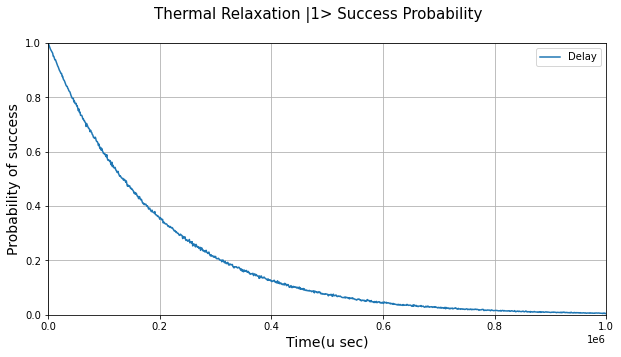

<Figure size 576x360 with 0 Axes>

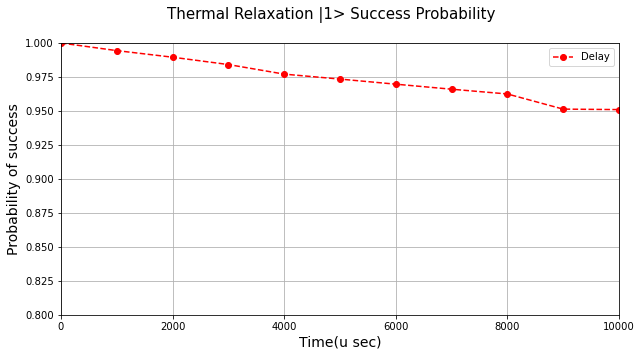

<Figure size 576x360 with 0 Axes>

In [16]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,bb84_state_1_1,label = "Delay")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 10000)
ax.set_ylim(0.8,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,bb84_state_1_1,'ro--',label = "Delay")
ax.legend()

# Delay +measure + gates

In [14]:
import matplotlib.pyplot as plt
success_state1=[]
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success_state1.append(success)

In [15]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.97455 0.9687 0.96315 0.9595 0.95355 0.9522499999999999 0.94335 0.9395 0.93785 0.9294 0.9269000000000001 0.9199 0.91405 0.9136000000000001 0.9041 0.8989 0.898 0.8958 0.8892 0.8847 0.87885 0.8721 0.8699 0.86115 0.8614499999999999 0.8516 0.8516 0.84955 0.84015 0.8369 0.8342999999999999 0.82855 0.82805 0.81495 0.8176 0.81835 0.8066 0.80635 0.798 0.797 0.79045 0.78835 0.7847000000000001 0.779 0.7753 0.7719 0.7666000000000001 0.76635 0.75385 0.75725 0.7534 0.7489 0.748 0.74155 0.7337 0.7316 0.73025 0.7284999999999999 0.7211 0.7133999999999999 0.7119 0.7081999999999999 0.7112999999999999 0.6971499999999999 0.7008 0.70005 0.6948 0.6871 0.68505 0.6788000000000001 0.6739 0.6706 0.6717500000000001 0.6681 0.66225 0.6519 0.6607500000000001 0.6501 0.6513 0.64705 0.6458 0.6434 0.6372 0.63525 0.6323 0.62545 0.6234 0.62075 0.61825 0.61015 0.61485 0.60675 0.6058 0.6003 0.60065 0.59155 0.59065 0.5861 0.58575 0.5879 0.58255 0.5777 0.5717 0.5696 0.568 0.5665 0.55775 0.56465 0.5532 0.5522 0.5486 0.5498000

In [16]:
bb84_state_1_4=[0.97455,0.9687,0.96315,0.9595,0.95355,0.9522499999999999,0.94335,0.9395,0.93785,0.9294,0.9269000000000001,0.9199,0.91405,0.9136000000000001,0.9041,0.8989,0.898,0.8958,0.8892,0.8847,0.87885,0.8721,0.8699,0.86115,0.8614499999999999,0.8516,0.8516,0.84955,0.84015,0.8369,0.8342999999999999,0.82855,0.82805,0.81495,0.8176,0.81835,0.8066,0.80635,0.798,0.797,0.79045,0.78835,0.7847000000000001,0.779,0.7753,0.7719,0.7666000000000001,0.76635,0.75385,0.75725,0.7534,0.7489,0.748,0.74155,0.7337,0.7316,0.73025,0.7284999999999999,0.7211,0.7133999999999999,0.7119,0.7081999999999999,0.7112999999999999,0.6971499999999999,0.7008,0.70005,0.6948,0.6871,0.68505,0.6788000000000001,0.6739,0.6706,0.6717500000000001,0.6681,0.66225,0.6519,0.6607500000000001,0.6501,0.6513,0.64705,0.6458,0.6434,0.6372,0.63525,0.6323,0.62545,0.6234,0.62075,0.61825,0.61015,0.61485,0.60675,0.6058,0.6003,0.60065,0.59155,0.59065,0.5861,0.58575,0.5879,0.58255,0.5777,0.5717,0.5696,0.568,0.5665,0.55775,0.56465,0.5532,0.5522,0.5486,0.5498000000000001,0.53995,0.5425,0.53835,0.5436,0.5323,0.5306000000000001,0.5326500000000001,0.53305,0.5177,0.5163,0.5186000000000001,0.5155000000000001,0.5123,0.51005,0.5092,0.5053,0.5085,0.4967,0.5028,0.4997,0.4908,0.49265,0.48875,0.48719999999999997,0.48045,0.47435,0.48085,0.47815,0.47104999999999997,0.4767,0.46545000000000003,0.46265,0.46305,0.45555,0.45765,0.45790000000000003,0.45640000000000003,0.44730000000000003,0.4501,0.44875,0.4364,0.4362,0.4409,0.433,0.4327,0.4355,0.42969999999999997,0.42885,0.41875,0.42075,0.42464999999999997,0.4225,0.4195,0.41075,0.4147,0.414,0.4094,0.40505,0.40245000000000003,0.4131,0.39625,0.3988,0.3972,0.3927,0.388,0.39545,0.3852,0.38880000000000003,0.37855,0.3807,0.38535,0.37595,0.37625,0.37885,0.36445,0.3718,0.36425,0.37205,0.3654,0.36265,0.3562,0.35825,0.3613,0.3514,0.3523,0.3478,0.35305,0.3423,0.3472,0.3499,0.3387,0.33695,0.3395,0.3422,0.33815,0.3313,0.3337,0.32615,0.3296,0.3279,0.3229,0.33015,0.32035,0.32615,0.3162,0.316,0.3157,0.3181,0.3142,0.31235,0.3157,0.3036,0.30419999999999997,0.3021,0.29725,0.30265,0.3039,0.30165,0.2958,0.2967,0.29159999999999997,0.2945,0.29165,0.2917,0.2864,0.2842,0.2821,0.28315,0.2831,0.27695000000000003,0.2786,0.27495,0.27535,0.27845,0.27165,0.2656,0.27055,0.2688,0.265,0.26665,0.2682,0.26205,0.2596,0.25935,0.2566,0.25680000000000003,0.2596,0.25625,0.2549,0.25245,0.251,0.2498,0.24675,0.24505,0.2455,0.24525,0.24375,0.24015,0.24035,0.23915,0.23695,0.2336,0.2393,0.23225,0.2412,0.23365,0.22705,0.22875,0.22455,0.23065,0.22785,0.2268,0.2288,0.22245,0.21915,0.21845,0.2216,0.21665,0.2201,0.2154,0.21235,0.2118,0.2138,0.20785,0.21185,0.2063,0.20395,0.2081,0.20115,0.20195,0.19615,0.20299999999999999,0.20305,0.1968,0.19705,0.19835,0.2022,0.19385,0.1963,0.194,0.1912,0.19005,0.18765,0.19415,0.191,0.18325,0.18765,0.1892,0.1869,0.1787,0.18259999999999998,0.18675,0.1815,0.177,0.17675,0.18125,0.1747,0.17785,0.1787,0.17895,0.1726,0.17195,0.1737,0.17205,0.1734,0.17265,0.17335,0.1674,0.1676,0.164,0.1679,0.1654,0.16105,0.16275,0.1617,0.1578,0.15675,0.1587,0.15585,0.16085,0.1603,0.15495,0.15375,0.1571,0.15075,0.1558,0.15365,0.1523,0.1545,0.15145,0.14835,0.14945,0.14625,0.14795,0.1532,0.14315,0.1462,0.14305,0.1425,0.14335,0.14035,0.13975,0.14015,0.14035,0.139,0.13765,0.1394,0.1341,0.13475,0.1354,0.13465,0.133,0.1328,0.1341,0.12840000000000001,0.1315,0.1311,0.13335,0.12535,0.1325,0.12735,0.1295,0.125,0.126,0.1268,0.1264,0.1231,0.1237,0.11750000000000001,0.122,0.12265,0.1197,0.1214,0.12040000000000001,0.1174,0.11985,0.11365,0.1176,0.11525,0.1139,0.11745,0.1165,0.11355,0.11255,0.10845,0.11515,0.10935,0.1109,0.1114,0.1129,0.10815,0.10755,0.10935,0.11015,0.10785,0.1086,0.10395,0.10389999999999999,0.10495,0.1048,0.10315,0.1051,0.1037,0.10295,0.1021,0.1036,0.1043,0.09845,0.0998,0.0984,0.09825,0.09605,0.09425,0.0988,0.10024999999999999,0.09675,0.0973,0.09465,0.09475,0.0968,0.09575,0.09025,0.093,0.09230000000000001,0.0922,0.0917,0.09175,0.09055,0.08985,0.08895,0.0902,0.08875,0.08915000000000001,0.0881,0.0886,0.08425,0.08745,0.08805,0.088,0.0857,0.0829,0.0831,0.0882,0.0831,0.0855,0.0802,0.07925,0.0834,0.07995,0.08105,0.08195,0.08115,0.07825,0.0784,0.0777,0.07605,0.0764,0.07795,0.07585,0.0801,0.0775,0.07315,0.0723,0.07605,0.07315,0.07125000000000001,0.0775,0.0757,0.07005,0.0716,0.0702,0.07305,0.0706,0.0709,0.06985,0.07215,0.07105,0.06945,0.06805,0.07100000000000001,0.0681,0.06795,0.0663,0.07005,0.06585,0.0661,0.06865,0.0684,0.06485,0.0658,0.0626,0.06765,0.06575,0.06645,0.0642,0.06420000000000001,0.06405,0.06695,0.06695,0.0649,0.0621,0.06315,0.0638,0.061649999999999996,0.06420000000000001,0.06215,0.0617,0.0591,0.057050000000000003,0.058499999999999996,0.05845,0.05955,0.0582,0.0564,0.0568,0.058,0.05675,0.0568,0.05765,0.0523,0.0583,0.0549,0.05515,0.05275,0.05245,0.05455,0.0582,0.05005,0.052,0.0524,0.0523,0.05495,0.05225,0.051449999999999996,0.0535,0.05155,0.0499,0.05095,0.0525,0.0512,0.04925,0.0526,0.04925,0.0508,0.0483,0.05055,0.04635,0.0483,0.0477,0.04665,0.05,0.048,0.04765,0.04645,0.04965,0.047599999999999996,0.04605,0.0436,0.0468,0.04835,0.04545,0.0431,0.0461,0.0451,0.04235,0.04665,0.0456,0.0443,0.0433,0.0427,0.04385,0.0434,0.0461,0.03815,0.04295,0.04165,0.04255,0.04205,0.0416,0.0391,0.0405,0.04105,0.03955,0.0398,0.0423,0.038400000000000004,0.04065,0.0417,0.0393,0.03945,0.0376,0.03695,0.039,0.0383,0.03665,0.03655,0.0373,0.03805,0.0363,0.037,0.0375,0.0369,0.03675,0.03635,0.03515,0.03485,0.03545,0.0381,0.0343,0.03705,0.03535,0.0331,0.03305,0.03425,0.0363,0.03445,0.0334,0.0358,0.03185,0.0315,0.03375,0.034300000000000004,0.03325,0.0341,0.03135,0.03055,0.03175,0.0343,0.0305,0.03205,0.03225,0.030950000000000002,0.03205,0.03125,0.0317,0.02995,0.02805,0.027,0.03025,0.0309,0.032100000000000004,0.02845,0.0285,0.02825,0.02795,0.02805,0.0291,0.027800000000000002,0.028650000000000002,0.02655,0.03045,0.02705,0.02955,0.02935,0.0262,0.02725,0.02995,0.0264,0.0281,0.02665,0.026949999999999998,0.0266,0.0263,0.0271,0.0253,0.0254,0.02345,0.02575,0.0246,0.02825,0.0271,0.02625,0.02565,0.02535,0.027,0.0251,0.0258,0.02475,0.0246,0.02335,0.0257,0.02525,0.0244,0.0213,0.024,0.02455,0.0209,0.02445,0.0233,0.02195,0.0221,0.02325,0.0223,0.0218,0.02405,0.0212,0.02205,0.02275,0.02245,0.02135,0.02215,0.0217,0.0219,0.022350000000000002,0.0217,0.02105,0.0206,0.0194,0.021,0.021,0.0224,0.0205,0.0197,0.0212,0.0219,0.01855,0.0204,0.0204,0.01915,0.0202,0.02045,0.01925,0.01955,0.0199,0.019200000000000002,0.0212,0.0179,0.01895,0.01865,0.0187,0.01905,0.0176,0.02,0.02015,0.01935,0.0196,0.0181,0.0175,0.01635,0.01845,0.016900000000000002,0.0184,0.0189,0.01825,0.0195,0.01855,0.0177,0.01705,0.01625,0.01745,0.0169,0.01655,0.01775,0.0172,0.01695,0.015050000000000001,0.01495,0.01595,0.0158,0.018,0.01555,0.01745,0.01545,0.01535,0.01405,0.01665,0.01625,0.0158,0.01505,0.01395,0.01645,0.01555,0.0141,0.01565,0.01485,0.01695,0.0157,0.01385,0.0164,0.01485,0.015600000000000001,0.01455,0.01375,0.01625,0.0143,0.0157,0.01545,0.0151,0.0137,0.01405,0.01345,0.01405,0.0128,0.0147,0.0125,0.0148,0.014199999999999999,0.01335,0.01355,0.0137,0.0133,0.01395,0.0106,0.0135,0.013,0.0131,0.0141,0.01235,0.0117,0.0114,0.01205,0.0113,0.0124,0.011899999999999999,0.01245,0.01215,0.0123,0.0114,0.01265,0.012199999999999999,0.0119,0.013,0.012199999999999999,0.01185,0.0115,0.0123,0.0115,0.01175,0.011349999999999999,0.012199999999999999,0.01205,0.010199999999999999,0.0108,0.0108,0.01045,0.01175,0.0121,0.0101,0.0111,0.0103,0.01095,0.01185,0.0115,0.00995,0.010499999999999999,0.0098,0.0105,0.00925,0.0103,0.00955,0.0096,0.00885,0.0091,0.01055,0.00915,0.0097,0.00995,0.00955,0.01035,0.01,0.0099,0.00885,0.0093,0.00845,0.009,0.01005,0.0094,0.00935,0.01035,0.00985,0.00865,0.00825,0.00835,0.01035,0.008,0.0088,0.00885,0.008150000000000001,0.0101,0.0083,0.0091,0.00925,0.0082,0.009899999999999999,0.0075,0.0076,0.00925,0.00865,0.00835,0.0087,0.0088,0.00745,0.0086,0.00865,0.007899999999999999,0.00725,0.00835,0.0078,0.00815,0.0073,0.00945,0.00795,0.00805,0.00675,0.00715,0.00735,0.00785,0.00855,0.00755,0.0064,0.0073999999999999995,0.00735,0.00775,0.0072,0.0065,0.0078,0.00745,0.0071,0.0081,0.00655,0.00775,0.007,0.00735,0.0068000000000000005,0.00595,0.0068000000000000005,0.00715,0.00595,0.0072,0.0068,0.0064,0.00605,0.007,0.0065,0.00655,0.00685,0.00625,0.00725,0.00525,0.0068,0.0056500000000000005,0.00555,0.006,0.00525,0.00745,0.00705,0.0058000000000000005,0.0054,0.00525,0.0059,0.0057,0.00555,0.007,0.0053,0.0058000000000000005,0.00555,0.00495,0.005,0.0054,0.00605,0.00695,0.00685,0.00525,0.00535,0.00575,0.0051,0.0061,0.0057,0.0043]

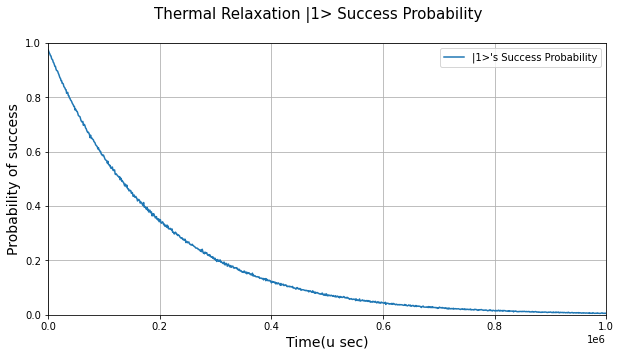

<Figure size 576x360 with 0 Axes>

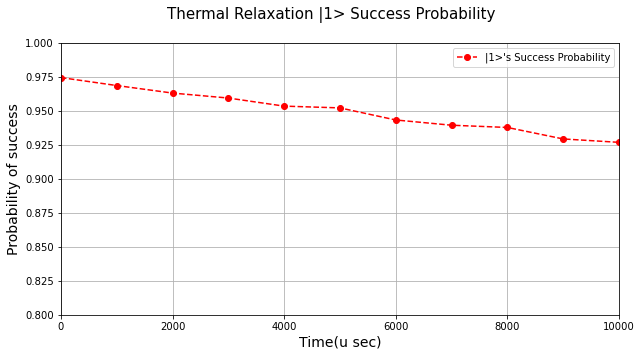

<Figure size 576x360 with 0 Axes>

In [17]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,bb84_state_1_4,label = "|1>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 10000)
ax.set_ylim(0.8,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,bb84_state_1_4,'ro--',label = "|1>'s Success Probability")
ax.legend()

# Plus State

# Delay

In [15]:
import matplotlib.pyplot as plt
success1 = []
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []
        # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success1.append(success)

In [16]:
from statistics import mean
a= success1
print(*map(mean, zip(*a)))

0.99885 0.99445 0.9911 0.99075 0.9932 0.98885 0.98175 0.987 0.9744999999999999 0.97575 0.973 0.9781 0.9679 0.96375 0.9599 0.9663499999999999 0.95585 0.96 0.9567 0.9544 0.9517 0.9461499999999999 0.9501999999999999 0.9402 0.9381 0.9418 0.9453 0.928 0.93095 0.93015 0.93105 0.9275 0.9246 0.9224 0.91865 0.90945 0.90705 0.9181 0.9116500000000001 0.9052 0.90995 0.9005500000000001 0.9041 0.8966000000000001 0.9032 0.8999 0.89545 0.8956500000000001 0.8913 0.8943 0.8876000000000001 0.8863 0.88485 0.8807 0.88425 0.8778 0.8765000000000001 0.87335 0.8693 0.86715 0.86685 0.8613999999999999 0.8654 0.8584499999999999 0.8543499999999999 0.86695 0.8593 0.8445 0.8517 0.85 0.83955 0.8446 0.8412999999999999 0.8401 0.8398 0.8406 0.8403999999999999 0.8389 0.8366 0.8332999999999999 0.83155 0.8312999999999999 0.8222 0.8274 0.82505 0.8251999999999999 0.81595 0.8148 0.81395 0.8163 0.81445 0.8167 0.81375 0.8058500000000001 0.80565 0.80015 0.8007500000000001 0.80815 0.79395 0.80365 0.79445 0.7962 0.78985 0.80025 0.

In [23]:
b1=[0.99885,0.99445,0.9911,0.99075,0.9932,0.98885,0.98175,0.987,0.9744999999999999,0.97575,0.973,0.9781,0.9679,0.96375,0.9599,0.9663499999999999,0.95585,0.96,0.9567,0.9544,0.9517,0.9461499999999999,0.9501999999999999,0.9402,0.9381,0.9418,0.9453,0.928,0.93095,0.93015,0.93105,0.9275,0.9246,0.9224,0.91865,0.90945,0.90705,0.9181,0.9116500000000001,0.9052,0.90995,0.9005500000000001,0.9041,0.8966000000000001,0.9032,0.8999,0.89545,0.8956500000000001,0.8913,0.8943,0.8876000000000001,0.8863,0.88485,0.8807,0.88425,0.8778,0.8765000000000001,0.87335,0.8693,0.86715,0.86685,0.8613999999999999,0.8654,0.8584499999999999,0.8543499999999999,0.86695,0.8593,0.8445,0.8517,0.85,0.83955,0.8446,0.8412999999999999,0.8401,0.8398,0.8406,0.8403999999999999,0.8389,0.8366,0.8332999999999999,0.83155,0.8312999999999999,0.8222,0.8274,0.82505,0.8251999999999999,0.81595,0.8148,0.81395,0.8163,0.81445,0.8167,0.81375,0.8058500000000001,0.80565,0.80015,0.8007500000000001,0.80815,0.79395,0.80365,0.79445,0.7962,0.78985,0.80025,0.79185,0.7886000000000001,0.79405,0.7837000000000001,0.78635,0.78135,0.79395,0.7817000000000001,0.78105,0.7776500000000001,0.7744,0.77575,0.77315,0.7731,0.7724,0.7705500000000001,0.7704,0.7639,0.76175,0.7561,0.7633,0.7607,0.76065,0.75815,0.75805,0.7533,0.7564,0.74985,0.7492,0.74995,0.7501,0.74615,0.7522,0.7475,0.7447,0.7484999999999999,0.7424999999999999,0.7435,0.73875,0.7381,0.7386,0.74135,0.7346,0.7349,0.72985,0.7294499999999999,0.72695,0.72685,0.7212,0.727,0.7263,0.7221,0.7202999999999999,0.7221,0.7213999999999999,0.7177,0.7222,0.7163499999999999,0.71765,0.7133999999999999,0.7156,0.7168,0.7066,0.70365,0.70965,0.7061,0.70815,0.7052499999999999,0.7054,0.7028,0.70005,0.7004,0.70045,0.69705,0.70075,0.6971499999999999,0.6986,0.69235,0.69485,0.69285,0.6925,0.6947,0.69255,0.69025,0.6918,0.6922,0.6877,0.6771,0.6859,0.6869999999999999,0.68785,0.68515,0.67625,0.68425,0.67925,0.6753,0.68165,0.6806,0.67825,0.6707000000000001,0.6705,0.67615,0.6739,0.67205,0.6708500000000001,0.6693,0.6654,0.66805,0.6695,0.6643,0.6675,0.6623,0.6654,0.6597500000000001,0.66195,0.66335,0.65725,0.6585500000000001,0.6573,0.6595,0.6555500000000001,0.6568,0.6504,0.6538,0.6548,0.6505500000000001,0.6516500000000001,0.6537000000000001,0.65085,0.64705,0.64895,0.6458,0.65085,0.6471,0.6461,0.64685,0.6465500000000001,0.64725,0.6446500000000001,0.6432,0.6446000000000001,0.6395500000000001,0.63795,0.64235,0.63845,0.63945,0.64175,0.63235,0.63605,0.63435,0.6311,0.63115,0.63185,0.62975,0.63285,0.6321,0.63405,0.62935,0.62875,0.6278,0.62965,0.63065,0.62755,0.62305,0.6207,0.626,0.6217,0.62335,0.6239,0.61825,0.62085,0.62005,0.6205,0.61495,0.6161,0.61915,0.62165,0.619,0.6152,0.6134,0.6153,0.61305,0.613,0.6125,0.6105,0.6108,0.6118,0.6114999999999999,0.6082,0.60825,0.60995,0.60565,0.61075,0.60665,0.60775,0.6087,0.6083999999999999,0.6069,0.6063999999999999,0.60185,0.6049,0.60265,0.6029,0.6003999999999999,0.59885,0.60055,0.60405,0.60185,0.5974999999999999,0.59695,0.5984499999999999,0.5971,0.59615,0.596,0.5946,0.59205,0.5972,0.593,0.5953499999999999,0.5954999999999999,0.5923499999999999,0.5917,0.5919,0.5908,0.59095,0.59085,0.5896,0.589,0.5894999999999999,0.589,0.58995,0.5902499999999999,0.58315,0.5877,0.58655,0.5843499999999999,0.5829,0.58895,0.5862499999999999,0.5839,0.5843999999999999,0.5863499999999999,0.5824499999999999,0.5788,0.5842499999999999,0.58215,0.5804499999999999,0.5806,0.57855,0.5814499999999999,0.58085,0.5801499999999999,0.57765,0.57895,0.5781999999999999,0.578,0.5773499999999999,0.57475,0.5761,0.57595,0.57455,0.57475,0.5723499999999999,0.5748,0.5733499999999999,0.578,0.57095,0.5732499999999999,0.5761999999999999,0.5716,0.5681999999999999,0.571,0.5716,0.56985,0.56995,0.5763499999999999,0.5690999999999999,0.568,0.5680999999999999,0.5668,0.5697,0.57145,0.5682499999999999,0.5671999999999999,0.5628,0.56545,0.56765,0.56685,0.5677,0.5649,0.5626,0.56655,0.5628,0.5599000000000001,0.5652499999999999,0.56025,0.5650499999999999,0.5604,0.5628,0.5613,0.56125,0.56195,0.56165,0.5627,0.55945,0.56165,0.56105,0.55945,0.5589500000000001,0.55845,0.562,0.5606,0.55855,0.5577,0.5575,0.5529000000000001,0.55635,0.5568000000000001,0.5551,0.55755,0.5556000000000001,0.55625,0.55525,0.55715,0.5537500000000001,0.5541,0.55565,0.55495,0.5534,0.55415,0.55255,0.5518000000000001,0.5526500000000001,0.5535,0.5537000000000001,0.5539000000000001,0.5514,0.55135,0.5496500000000001,0.5498000000000001,0.5518000000000001,0.54595,0.54895,0.5494,0.5486500000000001,0.5486500000000001,0.5493,0.5472,0.5459,0.548,0.5481,0.5478500000000001,0.5485500000000001,0.5481,0.5465500000000001,0.5467000000000001,0.5459,0.5466000000000001,0.54855,0.54415,0.54545,0.5438500000000001,0.5473,0.5455500000000001,0.5446500000000001,0.5444,0.5449,0.5406500000000001,0.5421,0.5403,0.54195,0.54035,0.54415,0.5429,0.54395,0.54145,0.54025,0.5387500000000001,0.54135,0.5395000000000001,0.5406000000000001,0.539,0.53845,0.54045,0.54105,0.5381,0.53625,0.5387500000000001,0.53915,0.5392,0.5395500000000001,0.5415000000000001,0.54005,0.5386500000000001,0.5365500000000001,0.5394,0.53725,0.5377500000000001,0.5339,0.5372,0.5375000000000001,0.5353,0.53695,0.53825,0.5349,0.534,0.53485,0.5372,0.5347000000000001,0.5351,0.536,0.53445,0.5319,0.53395,0.5332,0.53335,0.5335000000000001,0.5326500000000001,0.5332,0.53485,0.53435,0.533,0.5357000000000001,0.5326500000000001,0.5327000000000001,0.5316500000000001,0.5322,0.5332,0.53225,0.5316000000000001,0.5309,0.5337000000000001,0.53305,0.5309,0.52935,0.531,0.5296000000000001,0.5293,0.52795,0.5298,0.53015,0.53205,0.52925,0.5298,0.5315000000000001,0.5276000000000001,0.52935,0.5276500000000001,0.5271,0.5275500000000001,0.52935,0.53025,0.52715,0.53015,0.5259,0.52835,0.527,0.52845,0.52795,0.5264,0.52715,0.5279,0.5273,0.5262,0.52725,0.5248,0.5264,0.5261,0.52485,0.5267000000000001,0.5246500000000001,0.52595,0.525,0.52515,0.525,0.5238,0.5241,0.5246500000000001,0.52475,0.5257000000000001,0.52385,0.5245,0.5234,0.5243,0.52325,0.5241,0.5236000000000001,0.52205,0.5218,0.5226500000000001,0.5229,0.5241,0.5225,0.5225,0.5227,0.5232,0.52385,0.5214,0.52245,0.5218,0.5224,0.52175,0.5205500000000001,0.52195,0.52185,0.5207,0.5206500000000001,0.52125,0.52295,0.5184,0.5196000000000001,0.5201,0.5195000000000001,0.5211,0.52105,0.5209,0.521,0.5213,0.5205,0.5183,0.52085,0.51995,0.52095,0.51915,0.51885,0.5192,0.51885,0.51815,0.52,0.5166000000000001,0.5193,0.51805,0.5195500000000001,0.518,0.51795,0.5173,0.5189,0.5197,0.51885,0.51835,0.51695,0.51715,0.5167,0.5167,0.5161,0.5173,0.5165,0.516,0.5169,0.51665,0.5165,0.5171,0.5155500000000001,0.5164,0.51545,0.5163,0.5165500000000001,0.51775,0.5165500000000001,0.5151,0.51535,0.5171,0.5162,0.51795,0.51515,0.51465,0.51815,0.51475,0.51505,0.5137,0.5158,0.5141,0.5153,0.51585,0.515,0.51525,0.5146000000000001,0.514,0.5163,0.5128,0.51475,0.51435,0.5138,0.5132,0.51435,0.51415,0.5138,0.5141,0.5143,0.51485,0.5128,0.514,0.5131,0.51345,0.51445,0.5135500000000001,0.51365,0.51545,0.51165,0.5132,0.51175,0.5144,0.51265,0.51205,0.51265,0.5136000000000001,0.51265,0.5119,0.5129,0.5138,0.5125,0.5119,0.5135000000000001,0.51275,0.51265,0.5134,0.5113,0.5118,0.51315,0.5124,0.51125,0.512,0.51195,0.5118,0.5115500000000001,0.51265,0.51275,0.51095,0.5101,0.511,0.5125,0.51095,0.5118,0.5097,0.51195,0.5115000000000001,0.5117,0.5107,0.51165,0.5114,0.51095,0.5108,0.5109,0.5095000000000001,0.51185,0.51105,0.5106,0.5101,0.5104,0.5107,0.5105500000000001,0.5099,0.509,0.51025,0.5097,0.5106,0.50975,0.50975,0.50925,0.5096,0.5102,0.5107,0.5093,0.50915,0.50915,0.5104,0.50985,0.5103,0.5081,0.50865,0.5095000000000001,0.5091,0.5095500000000001,0.5086,0.5085500000000001,0.5089,0.508,0.5082,0.50805,0.5084,0.50785,0.50885,0.50865,0.5082,0.5094,0.50895,0.5084,0.50835,0.5086,0.50835,0.5093,0.50865,0.50735,0.50765,0.50765,0.5085,0.5086,0.50785,0.50775,0.5075000000000001,0.5075000000000001,0.50895,0.5082,0.5078,0.50745,0.50645,0.5079,0.5072,0.50795,0.50745,0.5069,0.50745,0.5075500000000001,0.5073,0.507,0.5068,0.5072,0.50725,0.5064,0.50765,0.5074,0.5065,0.5075000000000001,0.5073,0.5065500000000001,0.5075000000000001,0.50775,0.5068,0.5071,0.50765,0.5067,0.50605,0.50735,0.50685,0.50635,0.5065,0.5059,0.5058,0.50525,0.50575,0.50675,0.5058,0.5062,0.50635,0.5071,0.5058,0.50675,0.50685,0.50585,0.50615,0.5063,0.5068,0.5061,0.50645,0.50675,0.5047,0.5053,0.50565,0.5063,0.50595,0.5051,0.5056,0.5058,0.50485,0.5069,0.506,0.5057,0.50555,0.5062,0.505,0.50475,0.50425,0.5049,0.5046,0.5053,0.5065500000000001,0.50615,0.50485,0.5056,0.5049,0.50535,0.5048,0.5055000000000001,0.50525,0.50435,0.50445,0.5043,0.50515,0.50425,0.505,0.50485,0.5051,0.5046,0.5056,0.5052,0.50505,0.50435,0.5042,0.50445,0.50435,0.5043,0.505,0.5046,0.50365,0.5037,0.50455,0.5048,0.50395,0.5042,0.50435,0.5045,0.50445,0.5041,0.5042,0.50445,0.50355,0.50345,0.50435,0.50475,0.5043,0.50455,0.50465,0.5047,0.5039,0.50395,0.50415,0.5039,0.5037,0.50425,0.5045,0.5035000000000001,0.5034,0.50325,0.5036,0.5029,0.50355,0.5039,0.50365,0.5035000000000001,0.50415,0.5038,0.50305,0.50415,0.5051,0.5035000000000001,0.50455,0.50385,0.50335,0.50275,0.5034,0.50355,0.5027,0.503,0.50385,0.5035000000000001,0.5034,0.50375,0.50365,0.5024,0.50305,0.50275,0.50335,0.5034,0.50335,0.50395,0.50295,0.50285,0.50325,0.50325,0.5031,0.503,0.50295,0.5028,0.5027,0.5027,0.5033,0.5029,0.5031,0.50325,0.5031,0.50265,0.5029,0.503,0.50235,0.5033,0.50295,0.5027,0.50315,0.50255,0.50245,0.5032,0.5025,0.50345,0.5033,0.5024,0.5027,0.50295]


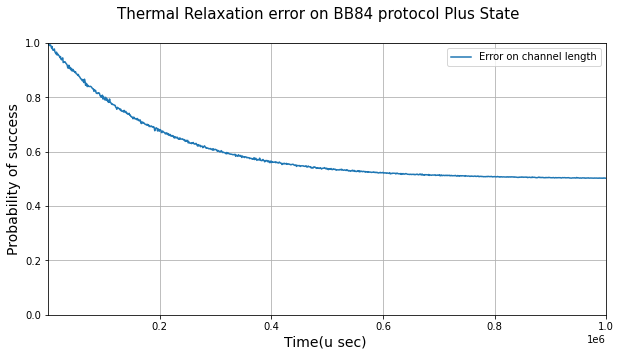

<Figure size 576x360 with 0 Axes>

In [24]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol Plus State',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b1,label = "Error on channel length")
ax.legend()

# Delay + gates

In [17]:
import matplotlib.pyplot as plt
success2 = []
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": False, "gate": True}
    success = []
        # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success2.append(success)

In [18]:
from statistics import mean
a= success2
print(*map(mean, zip(*a)))

0.99725 0.9972 0.9995499999999999 0.99405 0.98695 0.9843999999999999 0.98335 0.97895 0.9785999999999999 0.9714499999999999 0.9709 0.9703999999999999 0.9707 0.9688 0.9693499999999999 0.9633499999999999 0.9585 0.9542499999999999 0.95915 0.953 0.9545 0.9455 0.9454 0.9450999999999999 0.9435 0.9404 0.94045 0.9383 0.93585 0.93045 0.9298 0.92455 0.92635 0.91945 0.91385 0.91605 0.91305 0.9075500000000001 0.9056500000000001 0.91035 0.905 0.9061 0.9004 0.90205 0.899 0.89845 0.8956500000000001 0.8946500000000001 0.89165 0.8874 0.89035 0.8832 0.8827 0.88105 0.87885 0.87725 0.8758 0.8678 0.86875 0.86615 0.8623999999999999 0.863 0.8589 0.8607 0.85635 0.85395 0.8632 0.8514999999999999 0.84815 0.85835 0.8473999999999999 0.849 0.848 0.84405 0.83985 0.8336 0.8372999999999999 0.8412999999999999 0.83475 0.8314999999999999 0.8286 0.82885 0.82895 0.83165 0.8251999999999999 0.82285 0.82385 0.8213 0.822 0.8176 0.8133 0.8105 0.8135 0.8051 0.81305 0.8018000000000001 0.79745 0.80175 0.79825 0.80205 0.79515 0.793

In [25]:
b2=[0.99725,0.9972,0.9995499999999999,0.99405,0.98695,0.9843999999999999,0.98335,0.97895,0.9785999999999999,0.9714499999999999,0.9709,0.9703999999999999,0.9707,0.9688,0.9693499999999999,0.9633499999999999,0.9585,0.9542499999999999,0.95915,0.953,0.9545,0.9455,0.9454,0.9450999999999999,0.9435,0.9404,0.94045,0.9383,0.93585,0.93045,0.9298,0.92455,0.92635,0.91945,0.91385,0.91605,0.91305,0.9075500000000001,0.9056500000000001,0.91035,0.905,0.9061,0.9004,0.90205,0.899,0.89845,0.8956500000000001,0.8946500000000001,0.89165,0.8874,0.89035,0.8832,0.8827,0.88105,0.87885,0.87725,0.8758,0.8678,0.86875,0.86615,0.8623999999999999,0.863,0.8589,0.8607,0.85635,0.85395,0.8632,0.8514999999999999,0.84815,0.85835,0.8473999999999999,0.849,0.848,0.84405,0.83985,0.8336,0.8372999999999999,0.8412999999999999,0.83475,0.8314999999999999,0.8286,0.82885,0.82895,0.83165,0.8251999999999999,0.82285,0.82385,0.8213,0.822,0.8176,0.8133,0.8105,0.8135,0.8051,0.81305,0.8018000000000001,0.79745,0.80175,0.79825,0.80205,0.79515,0.79325,0.79405,0.7958000000000001,0.7883,0.7928000000000001,0.7906500000000001,0.79155,0.7881,0.7845500000000001,0.7853,0.7829,0.77615,0.77505,0.77595,0.7708,0.7704,0.76785,0.77845,0.77015,0.7703,0.76385,0.7673,0.7649,0.76195,0.757,0.76265,0.7622,0.75775,0.7575500000000001,0.7533,0.7525,0.75375,0.75155,0.75235,0.74325,0.74465,0.7407,0.7423,0.74715,0.7353999999999999,0.74215,0.7415,0.7364499999999999,0.7418,0.73535,0.73315,0.7328,0.7282,0.72775,0.7273,0.7299,0.7262,0.7191,0.7256,0.7263499999999999,0.72125,0.72265,0.716,0.7224999999999999,0.71805,0.72,0.7166,0.7109,0.7081,0.7143499999999999,0.71295,0.7135,0.7103999999999999,0.70805,0.7056,0.7101999999999999,0.7072499999999999,0.70245,0.702,0.7003999999999999,0.7042499999999999,0.6959,0.6982999999999999,0.69795,0.6911,0.69265,0.69365,0.6912,0.6910499999999999,0.6909,0.6959,0.69365,0.68945,0.68675,0.68875,0.6871,0.68225,0.68345,0.682,0.6817,0.68065,0.6774,0.68145,0.68005,0.6774,0.6799000000000001,0.67605,0.6801,0.6724,0.67255,0.67735,0.6703,0.66895,0.6671,0.66785,0.665,0.6663,0.66485,0.6618,0.6625500000000001,0.6646000000000001,0.6631,0.6594,0.663,0.658,0.6566000000000001,0.6595,0.65215,0.65685,0.65425,0.65445,0.65585,0.65475,0.65495,0.65235,0.6477,0.65245,0.6509,0.6438,0.65315,0.6512,0.646,0.6467,0.64225,0.64625,0.6405500000000001,0.64105,0.638,0.6372,0.63885,0.6386000000000001,0.64225,0.64035,0.6366,0.6376000000000001,0.6318,0.63615,0.63645,0.63195,0.6353,0.6365500000000001,0.6331,0.6317,0.62795,0.62725,0.62835,0.62575,0.6279,0.62735,0.62315,0.6228,0.62345,0.6258,0.62465,0.62375,0.6226,0.62385,0.61705,0.62255,0.6202,0.6212,0.61895,0.6188,0.6173,0.6186,0.6146,0.6189,0.61765,0.615,0.60865,0.61595,0.61135,0.609,0.6139,0.6134999999999999,0.6113999999999999,0.60805,0.6093999999999999,0.60785,0.6124499999999999,0.6083999999999999,0.60555,0.6071,0.6072,0.6027,0.6068,0.59985,0.60515,0.60375,0.6047,0.6009,0.6013499999999999,0.6053,0.5999,0.6029,0.59875,0.5953499999999999,0.5959,0.5992,0.59805,0.6019,0.5953999999999999,0.5954499999999999,0.59505,0.5968,0.594,0.5922,0.5904499999999999,0.5922,0.5923999999999999,0.5932,0.59505,0.5892999999999999,0.592,0.58915,0.5878,0.58965,0.5871999999999999,0.58815,0.5902,0.58555,0.5862499999999999,0.58755,0.58375,0.5851,0.5851999999999999,0.5827,0.5859,0.58075,0.5862999999999999,0.5836,0.5824499999999999,0.5801,0.581,0.5806,0.58065,0.5778,0.5805,0.5811,0.5786,0.5799,0.5775,0.5745,0.5763499999999999,0.57785,0.57565,0.57885,0.578,0.5763999999999999,0.57475,0.5742499999999999,0.5751999999999999,0.5751999999999999,0.575,0.57575,0.57395,0.5734,0.5703499999999999,0.5727,0.5723499999999999,0.57085,0.5680499999999999,0.57205,0.5702499999999999,0.5711499999999999,0.5685,0.5691499999999999,0.57,0.56535,0.5638,0.5660999999999999,0.56655,0.5678,0.56525,0.5680499999999999,0.566,0.56425,0.56495,0.56555,0.5637,0.56895,0.56525,0.5633,0.5618,0.5614,0.56305,0.56235,0.56245,0.56165,0.5630999999999999,0.5604,0.5609,0.55905,0.5592,0.55905,0.56025,0.5607,0.5596,0.5552,0.55665,0.55975,0.56135,0.557,0.5577,0.558,0.55495,0.5579500000000001,0.5568500000000001,0.55715,0.5543,0.55305,0.5543,0.5545500000000001,0.5567,0.5506500000000001,0.55435,0.55335,0.5523,0.5528500000000001,0.5518000000000001,0.5526500000000001,0.553,0.5506500000000001,0.5533,0.5516500000000001,0.5487000000000001,0.55015,0.5518000000000001,0.55015,0.5507500000000001,0.5524,0.55035,0.54805,0.5458500000000001,0.5506000000000001,0.548,0.5477500000000001,0.5512,0.548,0.5459,0.5448500000000001,0.54705,0.54755,0.54545,0.54745,0.5456500000000001,0.5465500000000001,0.5469,0.5456500000000001,0.544,0.54545,0.5445500000000001,0.546,0.54445,0.5426500000000001,0.5415000000000001,0.5452,0.5434,0.54335,0.5422,0.54415,0.5428000000000001,0.54085,0.54335,0.5415000000000001,0.54035,0.54285,0.5412,0.5405500000000001,0.53825,0.5407500000000001,0.5375000000000001,0.5396000000000001,0.54215,0.53885,0.5393,0.5385,0.54015,0.53815,0.5385500000000001,0.5393,0.5364,0.5393,0.5376500000000001,0.53685,0.5375500000000001,0.5387500000000001,0.53605,0.53615,0.53415,0.5367500000000001,0.53885,0.5351,0.5321,0.53505,0.537,0.5367500000000001,0.53605,0.5326500000000001,0.5337500000000001,0.5339,0.5345500000000001,0.53595,0.5326500000000001,0.53535,0.5342,0.5317500000000001,0.5335500000000001,0.5313,0.5325,0.5303,0.53105,0.5301,0.5332,0.5335000000000001,0.53195,0.5308,0.53045,0.5328,0.5314,0.52905,0.5297000000000001,0.52925,0.5288,0.5306500000000001,0.52895,0.52915,0.52975,0.52985,0.5301,0.52815,0.52815,0.5306500000000001,0.5295000000000001,0.53005,0.5289,0.52915,0.52645,0.5272,0.52585,0.52635,0.5285500000000001,0.5294,0.5305,0.52475,0.5288,0.52735,0.5254,0.5264,0.5281,0.5262,0.5236000000000001,0.52485,0.52645,0.52505,0.52645,0.5246000000000001,0.5258,0.52485,0.52385,0.52585,0.52635,0.52525,0.5265500000000001,0.52545,0.52535,0.5233,0.52395,0.5248,0.5235500000000001,0.52445,0.5244,0.5248,0.5247,0.5239,0.5225500000000001,0.5235000000000001,0.5246500000000001,0.52235,0.52285,0.52325,0.5219,0.52235,0.5235500000000001,0.52375,0.52115,0.52275,0.5218,0.522,0.5207,0.5216000000000001,0.52035,0.5216500000000001,0.52135,0.52225,0.5219,0.52015,0.52025,0.5219,0.52175,0.5216500000000001,0.5193,0.5205,0.52,0.5194,0.5198,0.52045,0.52075,0.5198,0.5189,0.5192,0.5219,0.51765,0.5195000000000001,0.51805,0.5186000000000001,0.5193,0.5195000000000001,0.51905,0.5191,0.5205500000000001,0.5191,0.51775,0.51785,0.51725,0.51865,0.5188,0.51735,0.517,0.5182,0.51765,0.51775,0.5179,0.51815,0.5173,0.5183,0.5166000000000001,0.5174,0.5175500000000001,0.51865,0.51875,0.51515,0.5164,0.51715,0.5162,0.5155000000000001,0.5165,0.5162,0.5164,0.518,0.51525,0.5168,0.5175000000000001,0.51535,0.51505,0.51505,0.51585,0.51445,0.51645,0.51505,0.515,0.51405,0.5145500000000001,0.5151,0.51395,0.51435,0.5143,0.51435,0.51445,0.514,0.5147,0.514,0.51415,0.5162,0.5144,0.51185,0.51425,0.514,0.5128,0.5115000000000001,0.5119,0.51365,0.513,0.51185,0.5142,0.5135500000000001,0.5133,0.51245,0.5135000000000001,0.5122,0.5135000000000001,0.51285,0.5126000000000001,0.5118,0.5125,0.51265,0.51315,0.5122,0.51235,0.5128,0.5122,0.51145,0.5131,0.51215,0.51215,0.51205,0.51135,0.5129,0.5123,0.5132,0.51285,0.5125,0.50975,0.5109,0.51075,0.51135,0.5118,0.5122,0.51185,0.5111,0.51225,0.5108,0.51045,0.50975,0.50985,0.51035,0.5115000000000001,0.51085,0.51005,0.5109,0.5102,0.5108,0.5105500000000001,0.5106,0.51035,0.5104,0.51005,0.5098,0.51095,0.51025,0.51005,0.5093,0.5102,0.5099,0.5103,0.511,0.5108,0.5089,0.50905,0.5088,0.5092,0.51,0.5101,0.50845,0.5078,0.5088,0.5095000000000001,0.509,0.51015,0.5085500000000001,0.50985,0.50865,0.5087,0.5091,0.50925,0.50845,0.50835,0.5085500000000001,0.50895,0.50805,0.5091,0.50825,0.5089,0.50825,0.5095000000000001,0.5083,0.5082,0.5084,0.508,0.5073,0.50825,0.50835,0.50895,0.50965,0.50745,0.5072,0.5079,0.5077,0.50695,0.5068,0.50785,0.5074,0.5083,0.5075500000000001,0.50735,0.50785,0.5074,0.5076,0.509,0.50805,0.5078,0.50705,0.5066,0.50845,0.50715,0.50675,0.5058,0.50555,0.5074,0.50675,0.50675,0.5068,0.50725,0.50645,0.50705,0.50685,0.50725,0.5062,0.507,0.50625,0.50735,0.50585,0.5064,0.5069,0.5065,0.5072,0.50665,0.5059,0.50585,0.5071,0.5067,0.50665,0.50605,0.50625,0.5069,0.50625,0.50595,0.5058,0.5053,0.506,0.5051,0.50585,0.50495,0.5058,0.50515,0.50615,0.50485,0.505,0.50485,0.50545,0.50585,0.506,0.5049,0.50515,0.50525,0.50515,0.50485,0.50565,0.5059,0.5049,0.50505,0.5057,0.50625,0.50645,0.5053,0.5052,0.5057,0.5052,0.50465,0.50505,0.5049,0.50495,0.50525,0.50535,0.5051,0.5061,0.5049,0.5046,0.50385,0.50485,0.50565,0.5054,0.5046,0.50485,0.50525,0.5046,0.50505,0.5048,0.50475,0.50455,0.5049,0.50435,0.504,0.50535,0.50365,0.5037,0.5044,0.5046,0.5046,0.50435,0.50475,0.50455,0.50475,0.50445,0.5044,0.50465,0.5044,0.5045,0.50385,0.50405,0.50365,0.5046,0.5044,0.504,0.5036,0.5046,0.50505,0.50345,0.50395,0.50365,0.50405,0.5037,0.50395,0.5035000000000001,0.5032,0.50375,0.504,0.504,0.50365,0.50305,0.50395,0.5033,0.5038,0.50385,0.5034,0.5045,0.5034,0.5033,0.5042,0.5043,0.50305,0.50355,0.5034,0.504,0.5036,0.5034,0.50415,0.5033,0.50335,0.5038,0.50435,0.50325,0.5038,0.50335,0.50315,0.50305,0.50345,0.5037,0.503,0.50315,0.50335,0.50325,0.5031,0.503,0.50285,0.50285,0.50305,0.503,0.50255,0.50385,0.50305,0.50365,0.5036,0.5029,0.5035000000000001,0.5034,0.50255,0.5025,0.50315,0.5026,0.5028,0.5036,0.50285,0.50325,0.50255]


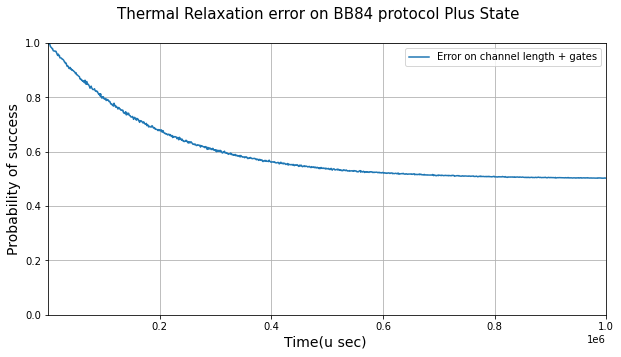

<Figure size 576x360 with 0 Axes>

In [26]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol Plus State',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b2,label = "Error on channel length + gates")
ax.legend()

# Delay+measurement

In [19]:
import matplotlib.pyplot as plt
success3 = []
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []
        # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success3.append(success)

In [20]:
from statistics import mean
a= success3
print(*map(mean, zip(*a)))

0.9923 0.9849 0.97925 0.9768 0.9822 0.97385 0.96815 0.9732999999999999 0.9753999999999999 0.9612999999999999 0.9657 0.9593499999999999 0.955 0.9552999999999999 0.94355 0.9551499999999999 0.95455 0.94565 0.94355 0.94485 0.9355 0.9369 0.9349 0.9298000000000001 0.92875 0.9294 0.9276 0.9219 0.92345 0.9189 0.9184 0.91345 0.9095 0.9116500000000001 0.91235 0.9095500000000001 0.90925 0.9038 0.90575 0.894 0.89675 0.89245 0.8869 0.88715 0.8904 0.8851 0.8823 0.8895500000000001 0.87605 0.88385 0.87355 0.87255 0.87575 0.8737 0.8696 0.86515 0.86515 0.8661 0.85755 0.8658 0.85485 0.8533499999999999 0.856 0.8554499999999999 0.8497 0.84795 0.85655 0.8442999999999999 0.842 0.83505 0.84115 0.832 0.83405 0.8347 0.8327 0.8281 0.82555 0.82505 0.8219 0.82095 0.82305 0.8159 0.8184 0.8122 0.8129 0.8058000000000001 0.80965 0.8104 0.80505 0.8081 0.805 0.8017500000000001 0.802 0.7961 0.8017000000000001 0.799 0.796 0.78945 0.793 0.79155 0.78605 0.7863 0.7847000000000001 0.78935 0.7843 0.78305 0.78235 0.7799 0.7724 

In [27]:
b3=[0.9923,0.9849,0.97925,0.9768,0.9822,0.97385,0.96815,0.9732999999999999,0.9753999999999999,0.9612999999999999,0.9657,0.9593499999999999,0.955,0.9552999999999999,0.94355,0.9551499999999999,0.95455,0.94565,0.94355,0.94485,0.9355,0.9369,0.9349,0.9298000000000001,0.92875,0.9294,0.9276,0.9219,0.92345,0.9189,0.9184,0.91345,0.9095,0.9116500000000001,0.91235,0.9095500000000001,0.90925,0.9038,0.90575,0.894,0.89675,0.89245,0.8869,0.88715,0.8904,0.8851,0.8823,0.8895500000000001,0.87605,0.88385,0.87355,0.87255,0.87575,0.8737,0.8696,0.86515,0.86515,0.8661,0.85755,0.8658,0.85485,0.8533499999999999,0.856,0.8554499999999999,0.8497,0.84795,0.85655,0.8442999999999999,0.842,0.83505,0.84115,0.832,0.83405,0.8347,0.8327,0.8281,0.82555,0.82505,0.8219,0.82095,0.82305,0.8159,0.8184,0.8122,0.8129,0.8058000000000001,0.80965,0.8104,0.80505,0.8081,0.805,0.8017500000000001,0.802,0.7961,0.8017000000000001,0.799,0.796,0.78945,0.793,0.79155,0.78605,0.7863,0.7847000000000001,0.78935,0.7843,0.78305,0.78235,0.7799,0.7724,0.77335,0.7786500000000001,0.76945,0.76805,0.7705,0.7672,0.771,0.7634,0.7691,0.7668,0.76595,0.7629,0.7665500000000001,0.7585500000000001,0.7547,0.7584,0.7605,0.74675,0.74965,0.74965,0.7515000000000001,0.7578,0.7464999999999999,0.742,0.7481,0.74115,0.74445,0.7411,0.7415,0.7371,0.7387,0.73505,0.729,0.7335,0.7324499999999999,0.7241,0.72615,0.7268,0.7272,0.7266,0.72575,0.7229,0.72205,0.72465,0.72465,0.7152,0.7193499999999999,0.71985,0.7139,0.7162,0.71775,0.7087,0.71175,0.71315,0.7103999999999999,0.7051,0.70765,0.7051,0.7073999999999999,0.70445,0.70385,0.71155,0.7016,0.70205,0.69455,0.7003999999999999,0.70375,0.6947,0.69445,0.6922,0.6910499999999999,0.69325,0.68845,0.6895,0.6901499999999999,0.68865,0.68695,0.68655,0.6814,0.6818,0.68415,0.6807,0.6802,0.67735,0.6832,0.67905,0.67505,0.6758500000000001,0.6788000000000001,0.67355,0.6677500000000001,0.6706500000000001,0.6732,0.67335,0.67205,0.6666500000000001,0.66715,0.66815,0.66505,0.6647500000000001,0.66245,0.6625000000000001,0.66685,0.6635,0.6657000000000001,0.6644,0.6603,0.66025,0.65635,0.65925,0.66105,0.6535500000000001,0.65815,0.6521,0.6516000000000001,0.656,0.6481,0.65205,0.64815,0.6512,0.6464,0.64725,0.649,0.6456500000000001,0.64275,0.6466000000000001,0.64495,0.6451,0.6413,0.6407,0.63645,0.64135,0.6454,0.64115,0.63635,0.6388,0.6382,0.6371,0.6359,0.63775,0.6328,0.6359,0.63275,0.63295,0.63065,0.63295,0.63145,0.6286,0.6305000000000001,0.63135,0.62515,0.63145,0.62565,0.6214,0.6258,0.62305,0.6216,0.62035,0.62235,0.6246,0.62,0.61985,0.6171,0.6159,0.61655,0.6159,0.6192,0.6154499999999999,0.61695,0.61055,0.6194,0.6122,0.61455,0.61365,0.61055,0.6132,0.6096,0.60885,0.6099,0.60905,0.6134999999999999,0.60655,0.6093,0.6067,0.6061,0.6041,0.60625,0.60685,0.6038,0.60635,0.60075,0.6013499999999999,0.6027,0.6017,0.6006,0.5999,0.59875,0.6003999999999999,0.6033,0.5991,0.59685,0.59795,0.59495,0.5997,0.598,0.59395,0.5934999999999999,0.59765,0.5964499999999999,0.59165,0.5936,0.5952999999999999,0.5872499999999999,0.5893999999999999,0.59355,0.5922499999999999,0.59005,0.5892999999999999,0.5937,0.59095,0.5882,0.58775,0.5882999999999999,0.5897,0.58575,0.58715,0.5892999999999999,0.587,0.5847,0.5864499999999999,0.58405,0.583,0.581,0.5819,0.5812499999999999,0.5801499999999999,0.5823499999999999,0.5798,0.58,0.5811,0.5782499999999999,0.5777,0.578,0.57965,0.57705,0.5779,0.5801999999999999,0.5771,0.57375,0.5735,0.57495,0.5740999999999999,0.57345,0.5732499999999999,0.5726,0.5746,0.5701499999999999,0.5718,0.5729,0.5722499999999999,0.56985,0.57705,0.5724,0.5690999999999999,0.56955,0.5693,0.5706,0.5670999999999999,0.5687,0.56745,0.56575,0.56955,0.56955,0.56685,0.565,0.56745,0.5674,0.56765,0.5666,0.5649,0.56465,0.56205,0.5649,0.56525,0.5618,0.5641499999999999,0.5638,0.56275,0.56365,0.5640499999999999,0.56085,0.5619,0.5609,0.55995,0.55925,0.56065,0.56105,0.5603,0.5595,0.5609000000000001,0.5587,0.5567,0.5577500000000001,0.5584,0.5556,0.557,0.55545,0.5526500000000001,0.5567,0.5583,0.55535,0.55715,0.556,0.5537000000000001,0.5548000000000001,0.55725,0.5547000000000001,0.5529000000000001,0.55305,0.55135,0.5554,0.55405,0.5505,0.55295,0.55115,0.55105,0.5506000000000001,0.5485,0.5506500000000001,0.5503,0.5494,0.5506000000000001,0.5483,0.5497500000000001,0.55055,0.5461,0.5505,0.54425,0.5472,0.5476000000000001,0.5457000000000001,0.5505,0.5467000000000001,0.5467000000000001,0.5476000000000001,0.54635,0.54535,0.54805,0.5435500000000001,0.54545,0.54545,0.5456000000000001,0.54325,0.5428000000000001,0.5441,0.5461,0.54045,0.54435,0.5432,0.54215,0.54245,0.5429,0.5447000000000001,0.5442,0.5419,0.5435000000000001,0.5413,0.5403,0.5427500000000001,0.54195,0.5407500000000001,0.54,0.5386000000000001,0.5405500000000001,0.5404,0.53915,0.541,0.53645,0.5387500000000001,0.5378000000000001,0.539,0.53925,0.5379,0.5385500000000001,0.53705,0.54105,0.53785,0.53715,0.53595,0.53615,0.53595,0.53845,0.53735,0.53805,0.5358,0.5354,0.5357000000000001,0.5346500000000001,0.5368,0.5336500000000001,0.5331,0.53515,0.534,0.53505,0.5357000000000001,0.53205,0.53425,0.5363,0.53405,0.5321,0.5319,0.53605,0.5322,0.5345,0.5312,0.53405,0.5319,0.5326500000000001,0.5301,0.5318,0.5309,0.5318,0.5295000000000001,0.5328,0.53205,0.52975,0.5321,0.53025,0.5305500000000001,0.5306500000000001,0.5292,0.53025,0.52915,0.5285,0.52885,0.5291,0.5307000000000001,0.5285500000000001,0.52875,0.5274,0.5285500000000001,0.5264,0.5286500000000001,0.52795,0.5273,0.52885,0.52705,0.52885,0.5278,0.5276000000000001,0.52795,0.5266500000000001,0.5287000000000001,0.5251,0.5269,0.5266500000000001,0.52795,0.5273,0.52735,0.52405,0.526,0.5262,0.5252,0.5239,0.52795,0.52315,0.5238,0.5236500000000001,0.52335,0.5255500000000001,0.5235500000000001,0.5221,0.525,0.5245500000000001,0.52295,0.52505,0.5236000000000001,0.52225,0.52545,0.5238,0.5232,0.5255500000000001,0.5215000000000001,0.52245,0.52295,0.5231,0.5235500000000001,0.52285,0.52375,0.52125,0.522,0.5206500000000001,0.52195,0.5195000000000001,0.52095,0.52005,0.5211,0.5201,0.52085,0.5209,0.522,0.5212,0.5198,0.5216500000000001,0.51935,0.5218,0.5207,0.5208,0.5185,0.5196000000000001,0.5207,0.5189,0.5201,0.5193,0.51895,0.5189,0.51925,0.51775,0.51865,0.5198,0.51835,0.518,0.5198,0.5192,0.51895,0.5188,0.5197,0.5198,0.51815,0.51815,0.5185,0.5178,0.5181,0.5172,0.51775,0.51745,0.51715,0.5174,0.51615,0.51605,0.51805,0.5165,0.51705,0.5182,0.51585,0.51705,0.5162,0.51575,0.51445,0.517,0.5177,0.5156000000000001,0.51575,0.5154,0.51435,0.5135500000000001,0.5155500000000001,0.51565,0.5163,0.5158,0.5149,0.5151,0.5152,0.514,0.5143,0.51485,0.51335,0.51415,0.51595,0.5147,0.5159,0.5145,0.51385,0.51425,0.5134,0.5133,0.5137,0.5152,0.51475,0.5145,0.51365,0.51535,0.514,0.5132,0.51295,0.5147,0.51425,0.51375,0.5135000000000001,0.51285,0.51315,0.51305,0.51345,0.5123,0.5133,0.51215,0.513,0.5136000000000001,0.5118,0.51325,0.51235,0.51345,0.51245,0.5145500000000001,0.5116,0.5118,0.5118,0.512,0.51265,0.51115,0.5113,0.51125,0.5108,0.51165,0.51275,0.5096,0.51025,0.51135,0.51245,0.51085,0.51125,0.5114,0.5115500000000001,0.5103,0.5092,0.5113,0.5109,0.5112,0.51065,0.511,0.5095500000000001,0.51015,0.50975,0.50865,0.5105500000000001,0.5106,0.51015,0.51065,0.5107,0.5095500000000001,0.5115500000000001,0.5099,0.5092,0.5097,0.50985,0.5102,0.50975,0.51,0.5097,0.50885,0.5098,0.50995,0.51015,0.51025,0.50935,0.50735,0.5089,0.50915,0.50935,0.5094,0.50945,0.51025,0.50845,0.50985,0.50885,0.5095000000000001,0.5095500000000001,0.5094,0.50835,0.5097,0.50835,0.5098,0.50945,0.508,0.5078,0.50815,0.5082,0.5088,0.50705,0.50815,0.5084,0.508,0.5086,0.5084,0.5074,0.5084,0.50845,0.5077,0.5071,0.50835,0.5086,0.50785,0.50715,0.508,0.50695,0.50845,0.5075000000000001,0.5078,0.5074,0.5074,0.5082,0.50765,0.50645,0.50805,0.50665,0.5084,0.50695,0.5068,0.50635,0.50765,0.5096,0.50685,0.5065,0.50715,0.50565,0.5078,0.50665,0.5061,0.5067,0.50545,0.50595,0.50685,0.50685,0.5076,0.50605,0.50735,0.5069,0.5071,0.50635,0.50705,0.5067,0.50595,0.5062,0.50555,0.5064,0.5066,0.50605,0.5058,0.5068,0.50615,0.50665,0.5056,0.50585,0.50695,0.50625,0.5063,0.5053,0.50585,0.5051,0.50565,0.506,0.50525,0.50605,0.5063,0.5053,0.5048,0.50495,0.50595,0.505,0.50525,0.5062,0.50545,0.5045,0.50545,0.505,0.50505,0.5053,0.5045,0.5047,0.5053,0.50525,0.50485,0.5053,0.50485,0.50475,0.5048,0.5055000000000001,0.50475,0.50405,0.50575,0.5052,0.5052,0.50495,0.5045,0.50405,0.50475,0.5044,0.50415,0.50455,0.50445,0.5043,0.50435,0.5037,0.5046,0.50415,0.5044,0.5046,0.5042,0.5044,0.5051,0.50395,0.50455,0.5047,0.50495,0.50435,0.50395,0.50455,0.50375,0.5048,0.50405,0.50405,0.5038,0.5036,0.50405,0.5044,0.50355,0.50395,0.5042,0.5047,0.5039,0.50445,0.50345,0.50385,0.50375,0.5034,0.5039,0.5042,0.50355,0.50415,0.5037,0.50365,0.5029,0.5044,0.5036,0.5041,0.50345,0.504,0.50365,0.5038,0.5039,0.50345,0.5034,0.50395,0.50355,0.50285,0.5033,0.50355,0.5035000000000001,0.5039,0.50295,0.50295,0.50355,0.503,0.5039,0.50305,0.5033,0.5032,0.5032,0.5031,0.5027,0.5037,0.50325,0.5033,0.50315,0.503,0.5038,0.50305,0.50275,0.50325,0.50315,0.50305,0.50255,0.50255,0.5031,0.50335,0.50225,0.503,0.50235,0.5032,0.50345,0.50315,0.50265,0.5028,0.50265,0.50275,0.5031,0.50295,0.5027,0.5028,0.5029,0.5024,0.5031]


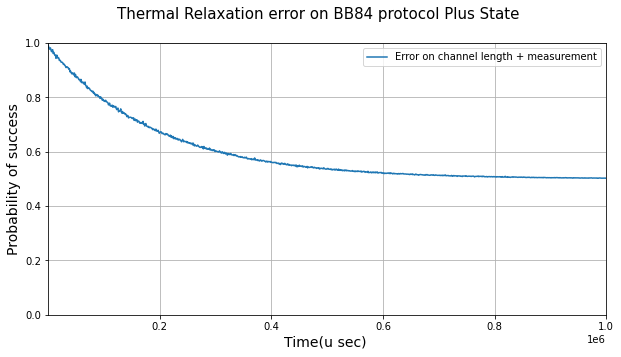

<Figure size 576x360 with 0 Axes>

In [28]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol Plus State',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b3,label = "Error on channel length + measurement")
ax.legend()

# Delay + measurement + gates

In [21]:
import matplotlib.pyplot as plt
success4 = []
for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []
        # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    success4.append(success)

In [22]:
from statistics import mean
a= success4
print(*map(mean, zip(*a)))

0.9902 0.9844999999999999 0.9733499999999999 0.97685 0.97365 0.9773499999999999 0.9672 0.9623999999999999 0.9694499999999999 0.96895 0.9616 0.9628 0.954 0.9566 0.94755 0.9508 0.95545 0.94755 0.94275 0.9459 0.93575 0.936 0.92745 0.93205 0.925 0.93225 0.92135 0.92965 0.92005 0.91935 0.9131 0.917 0.91625 0.91335 0.90185 0.9066000000000001 0.9002 0.9059 0.90225 0.89585 0.8998 0.89235 0.89425 0.88055 0.8849 0.88845 0.88875 0.8815500000000001 0.8801 0.8748 0.875 0.8714999999999999 0.86865 0.8717 0.87315 0.86205 0.86225 0.8594499999999999 0.8601 0.8562 0.85705 0.8581 0.85615 0.85405 0.8456 0.8434499999999999 0.8492 0.8489 0.8428 0.8443999999999999 0.8351999999999999 0.8351 0.83495 0.83475 0.8326 0.83475 0.8254 0.8264 0.8265 0.8272499999999999 0.8233 0.82955 0.8170999999999999 0.8190999999999999 0.80985 0.8167 0.81565 0.81265 0.80915 0.80495 0.8042 0.8048 0.8071 0.80515 0.7948500000000001 0.7968500000000001 0.7937500000000001 0.795 0.79455 0.793 0.7904 0.7865500000000001 0.7906000000000001 0.7

In [69]:
b4=[]


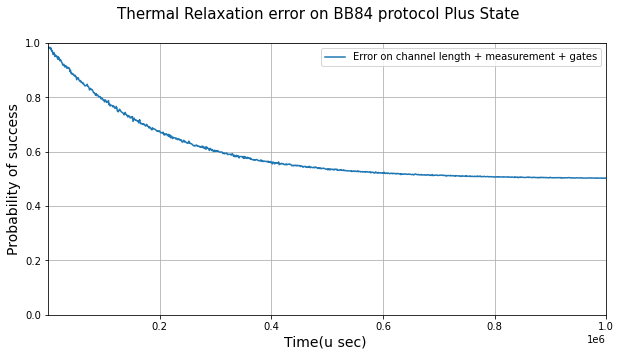

<Figure size 576x360 with 0 Axes>

In [70]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol Plus State',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b4,label = "Error on channel length + measurement + gates")
ax.legend()

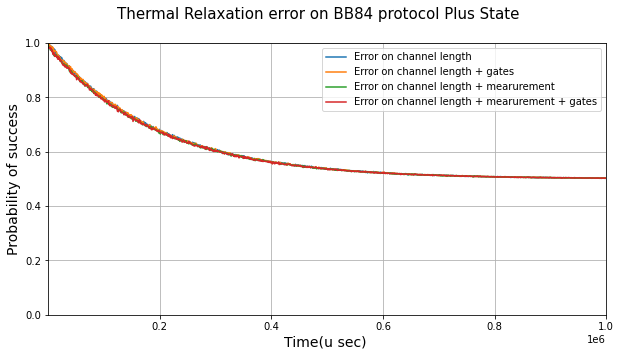

<Figure size 576x360 with 0 Axes>

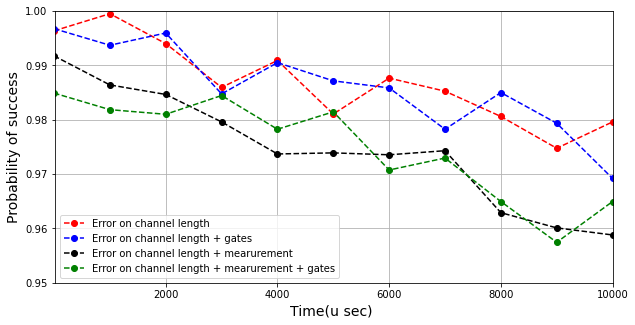

<Figure size 576x360 with 0 Axes>

In [71]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol Plus State',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b1,label = "Error on channel length")
ax.plot(delay,b2,label = "Error on channel length + gates")
ax.plot(delay,b3,label = "Error on channel length + mearurement")
ax.plot(delay,b4,label = "Error on channel length + mearurement + gates")
ax.legend()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.95,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b1,'ro--',label = "Error on channel length")
ax.plot(delay,b2,'bo--',label = "Error on channel length + gates")
ax.plot(delay,b3,'ko--',label = "Error on channel length + mearurement")
ax.plot(delay,b4,'go--',label = "Error on channel length + mearurement + gates")
ax.legend()


# Minus State

In [116]:
delay = np.arange(0,1001000,1000)
channel = '4'
apply_error = {"delay":True, "measure": True, "gate": False}
success = []

# need to run in multiple loops to get a smoother curve
for d in range(len(delay)):
    prob = run(channel,int(delay[d]),apply_error)
    success.append(prob)

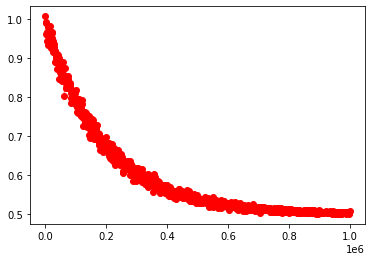

In [117]:
plt.plot(delay,success,'ro--')
plt.show()

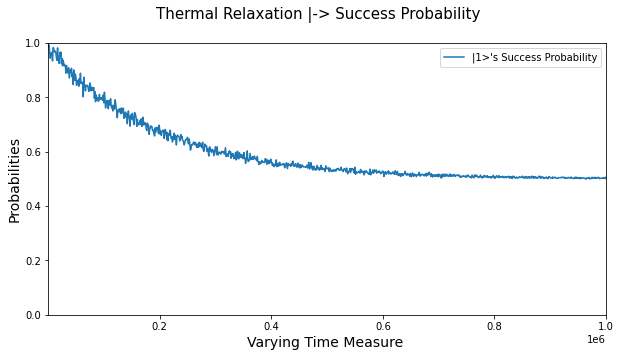

<Figure size 576x360 with 0 Axes>

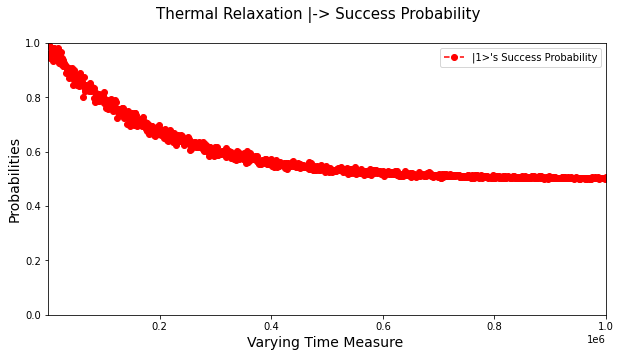

<Figure size 576x360 with 0 Axes>

In [118]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |-> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "|1>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |-> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "|1>'s Success Probability")
ax.legend()

In [120]:
# from statistics import mean
# a= y
# print(*map(mean, zip(*a)))